# Exploratory Data Analysis

Esse notebook é uma primeira visão aos dados.
Seu papel é validar os dados, identificar algum possível problema e dar insights para o pré-processamento de dados, possíveis segmentações e feature engineering.

Vamos:
- Validar a integridade dos dados
- Ver distribuições e identificar anomalias

# Entendimento do Problema

O dataset possui apenas dados de funcionários com ótima performance (excelente e fora da curva).<br>
Assim, é do interesse da área de Cultura e Pessoas entender quais fatores tem influência sobre o turnover (~16%).<br><br>
**Objetivos**
1. Identificar principais motivadores para a saída de funcionários;
2. Identificar grupos de funcionários com alta probabilidade de saída.

**Premissas**
- Dados são dos **EUA** uma vez que as variáveis estão em inglês;
- Dados coletados no mesmo período;
- Ocorrências de 0 na variável NumCompaniesWorked foi considerado como o primeiro ano de trabalho.

**Limitações**
- Não está especificado se os funcionários que sairam da empresa foram demitidos ou aposentaram;
- Sem features temporais;
- Sem dados próximos do cenário real (dados de funcionários que performaram mal).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import datetime
from plotting import plot_scatterplot

pd.set_option('max_rows', 250)
pd.set_option('max_columns', 50)
pd.set_option("display.precision", 3)

In [2]:
df = pd.read_excel('../Zup Test/data/HR.xlsx')
print(df.shape)
df.head(5)

(1470, 35)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [4]:
df["PerformanceRating"].value_counts()

3    1244
4     226
Name: PerformanceRating, dtype: int64

In [5]:
df["Attrition"].value_counts() * 100 / len(df)

No     83.878
Yes    16.122
Name: Attrition, dtype: float64

**Garantir que os ids são únicos:**

In [6]:
assert df['EmployeeNumber'].nunique() == len(df)

In [7]:
df.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000,1470.000,1470.000,1470.000,1470.0,1470.000,1470.000,1470.000,1470.000,1470.000,1470.000,1470.000,1470.000,1470.000,1470.00,1470.000,1470.000,1470.0,1470.000,1470.000,1470.000,1470.000,1470.000,1470.000,1470.000,1470.000
mean,36.924,802.486,9.193,2.913,1.0,1024.865,2.722,65.891,2.730,2.064,2.729,6502.931,14313.103,2.693,15.21,3.154,2.712,80.0,0.794,11.280,2.799,2.761,7.008,4.229,2.188,4.123
std,9.135,403.509,8.107,1.024,0.0,602.024,1.093,20.329,0.712,1.107,1.103,4707.957,7117.786,2.498,3.66,0.361,1.081,0.0,0.852,7.781,1.289,0.706,6.127,3.623,3.222,3.568
min,18.000,102.000,1.000,1.000,1.0,1.000,1.000,30.000,1.000,1.000,1.000,1009.000,2094.000,0.000,11.00,3.000,1.000,80.0,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000
25%,30.000,465.000,2.000,2.000,1.0,491.250,2.000,48.000,2.000,1.000,2.000,2911.000,8047.000,1.000,12.00,3.000,2.000,80.0,0.000,6.000,2.000,2.000,3.000,2.000,0.000,2.000
50%,36.000,802.000,7.000,3.000,1.0,1020.500,3.000,66.000,3.000,2.000,3.000,4919.000,14235.500,2.000,14.00,3.000,3.000,80.0,1.000,10.000,3.000,3.000,5.000,3.000,1.000,3.000
75%,43.000,1157.000,14.000,4.000,1.0,1555.750,4.000,83.750,3.000,3.000,4.000,8379.000,20461.500,4.000,18.00,3.000,4.000,80.0,1.000,15.000,3.000,3.000,9.000,7.000,3.000,7.000
max,60.000,1499.000,29.000,5.000,1.0,2068.000,4.000,100.000,4.000,5.000,4.000,19999.000,26999.000,9.000,25.00,4.000,4.000,80.0,3.000,40.000,6.000,4.000,40.000,18.000,15.000,17.000


# Problema nos dados

A coluna *Attrition* apresenta string ao invez de binário<br>
Aparentemente temos 3 colunas constantes e que portanto serão removidas:
- EmployeeCount 
- StandardHours
- Over18

A feature EmployeeNumber também será removida (não há relação temporal entre o ID e a data de entrada dos funcionários, o que torna a feature irrelevante)

In [8]:
df.drop(["EmployeeCount", "EmployeeNumber", "StandardHours", "Over18"], axis=1, inplace=True)

In [9]:
# Fix Attrition
df["Attrition"] = df["Attrition"].map({'Yes': 1, 'No': 0})
df["Attrition"].value_counts()

0    1233
1     237
Name: Attrition, dtype: int64

# Primeiros insights 
- Valores dentro do dóminio esperado 
- Target é skewed - ruim para modelos de regressão
- NumCompaniesWorked possui 197 ocorrências 0. Assumirei que o 0 seja a primeira empresa do funcionário

Exploremos as suas distribuições.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_op

<Figure size 432x288 with 0 Axes>

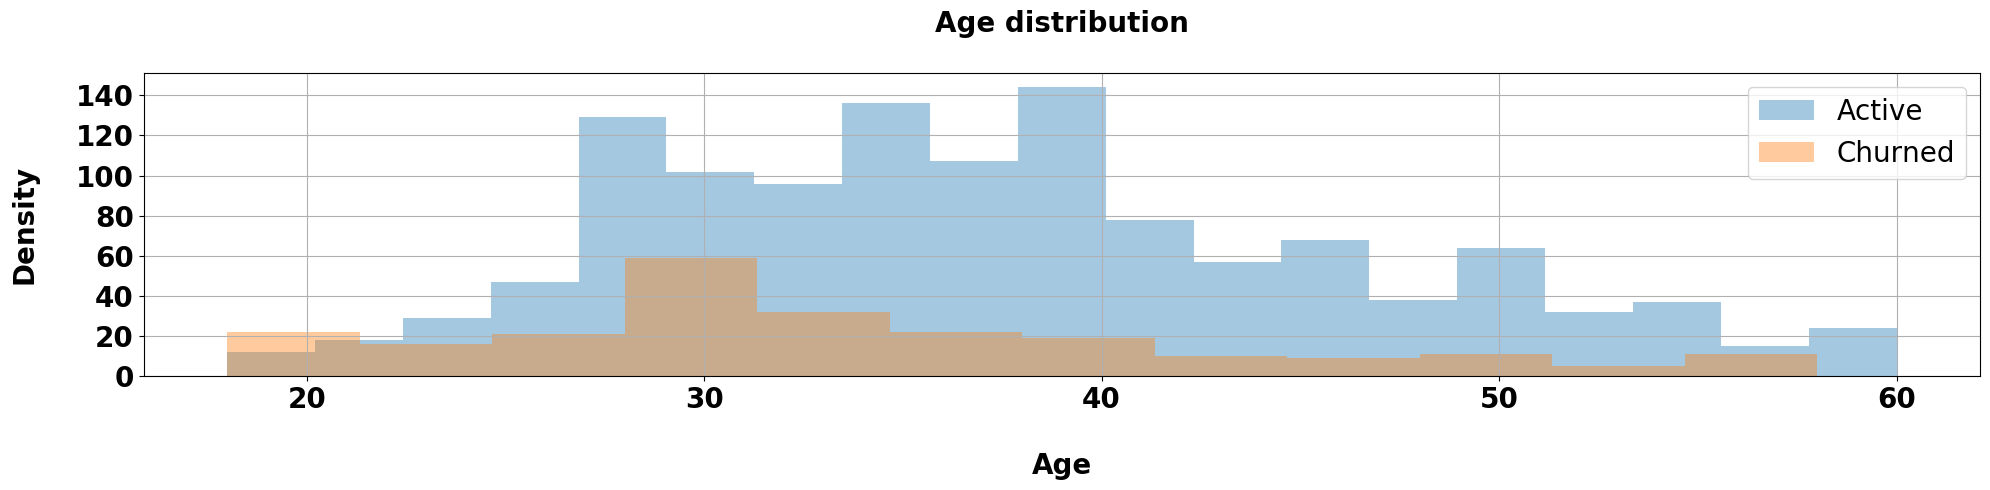

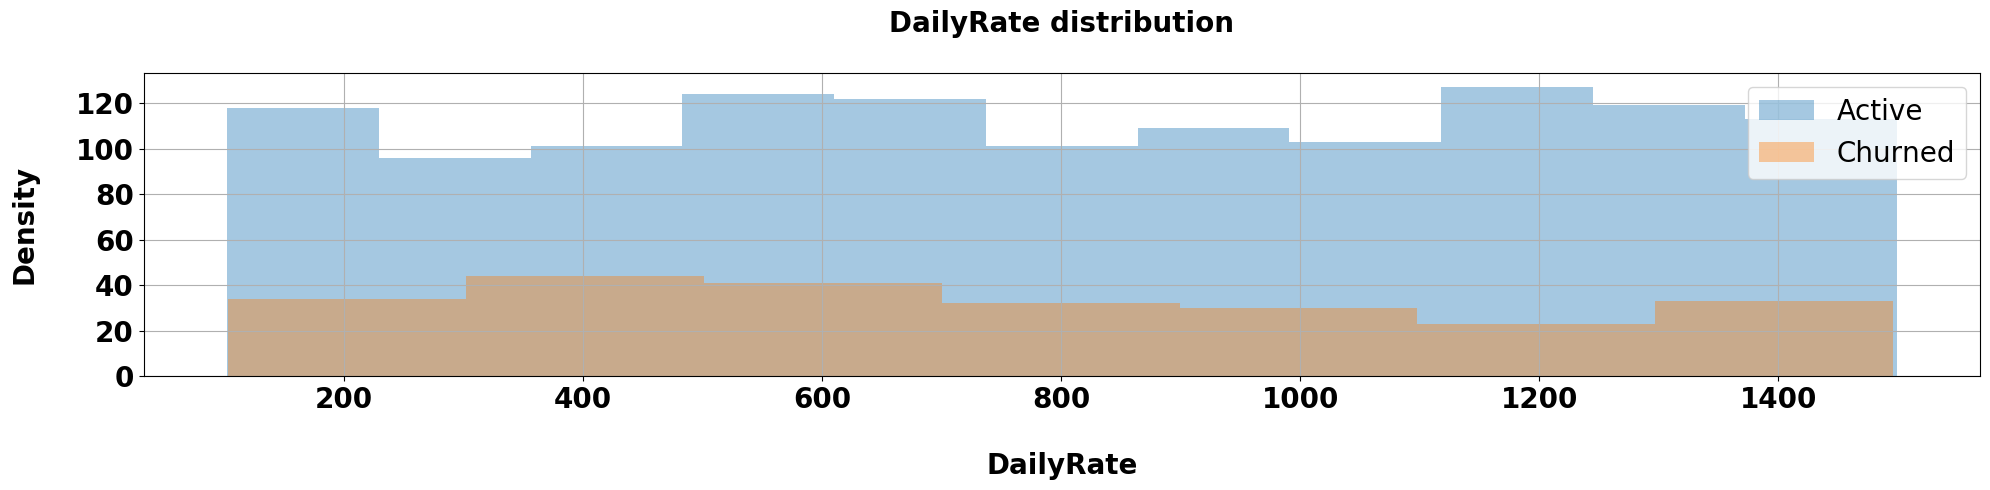

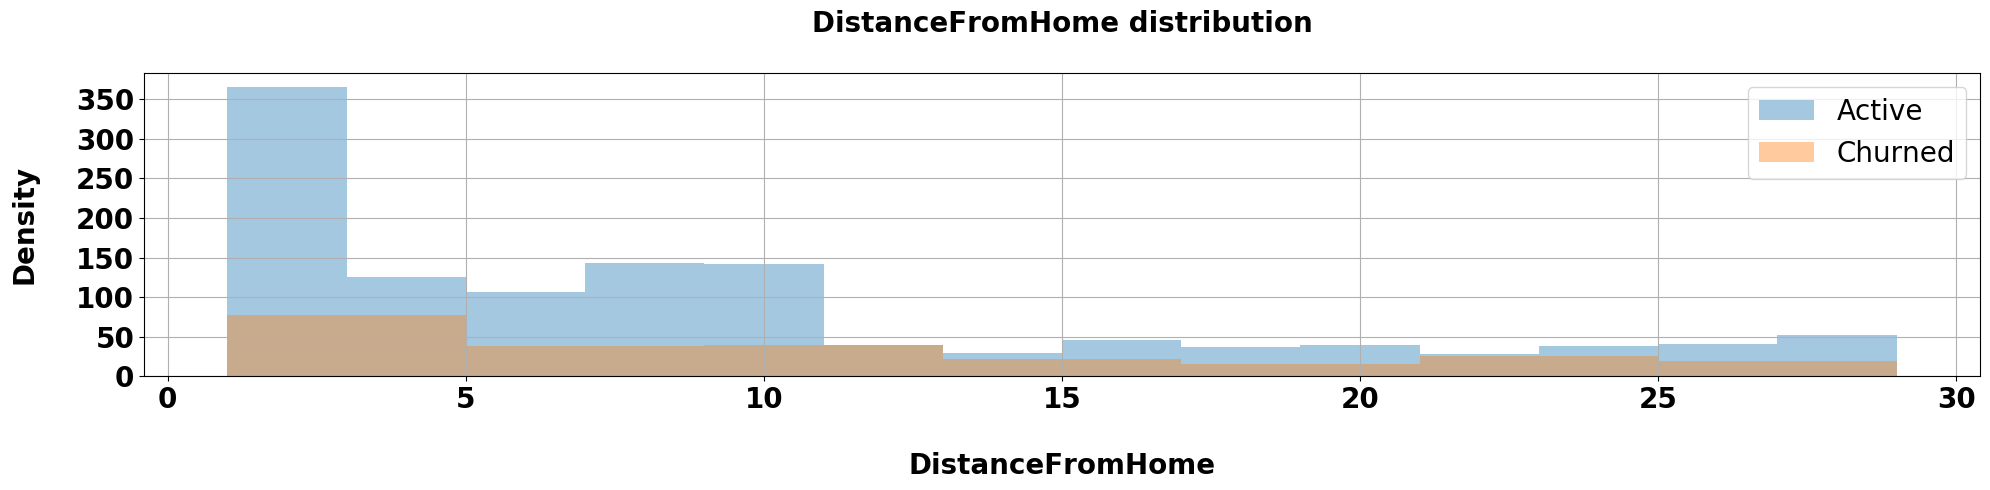

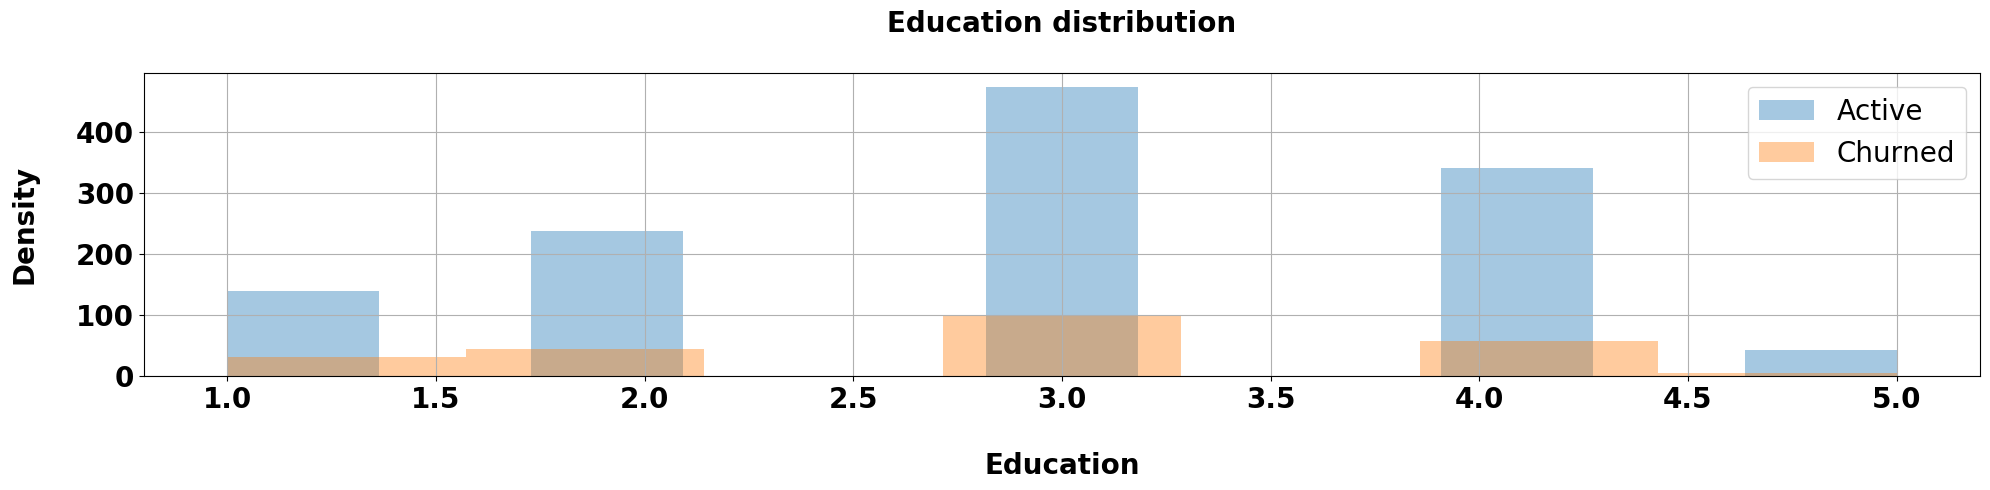

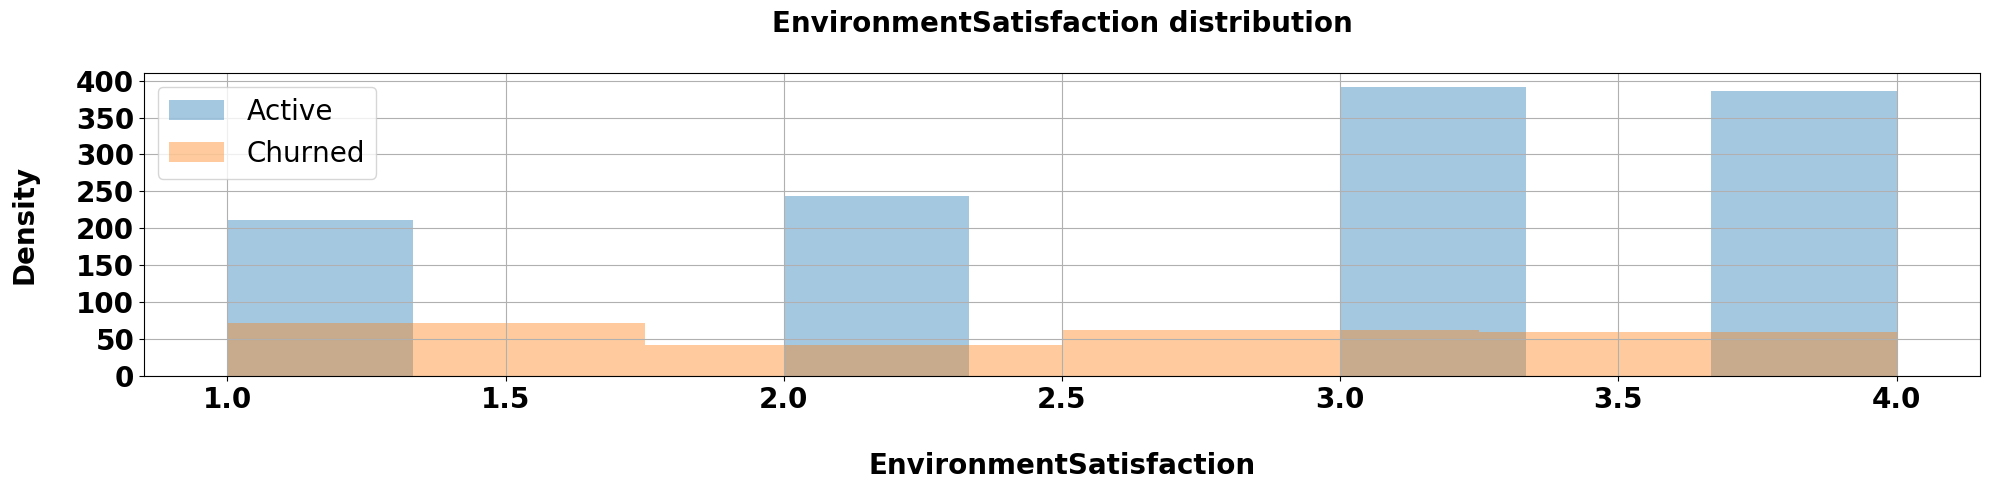

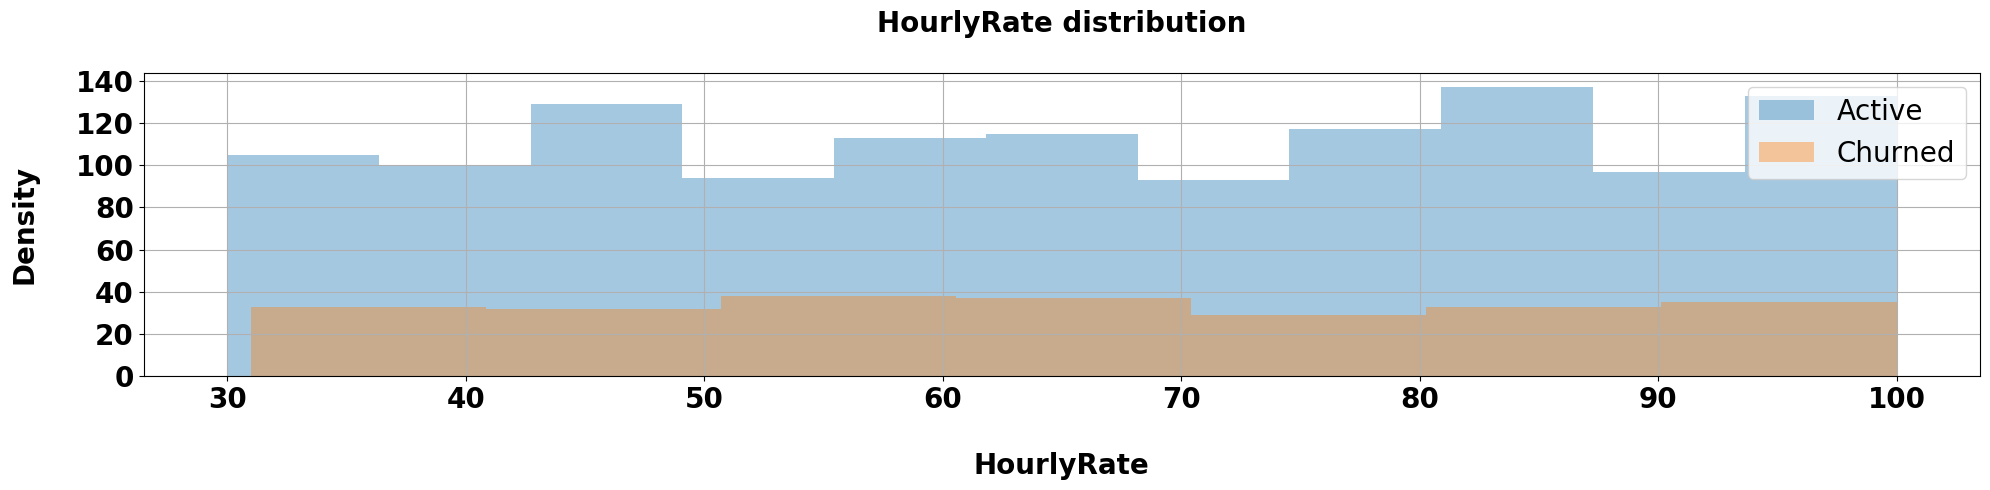

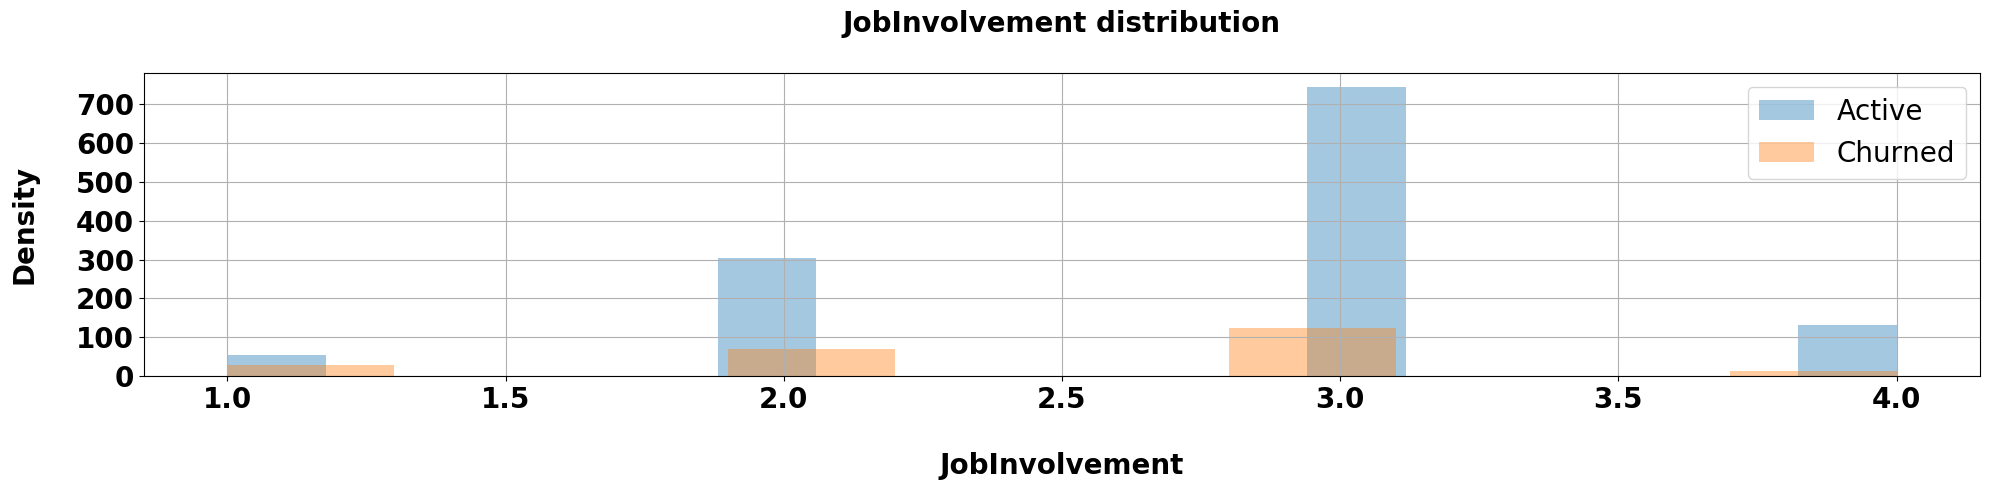

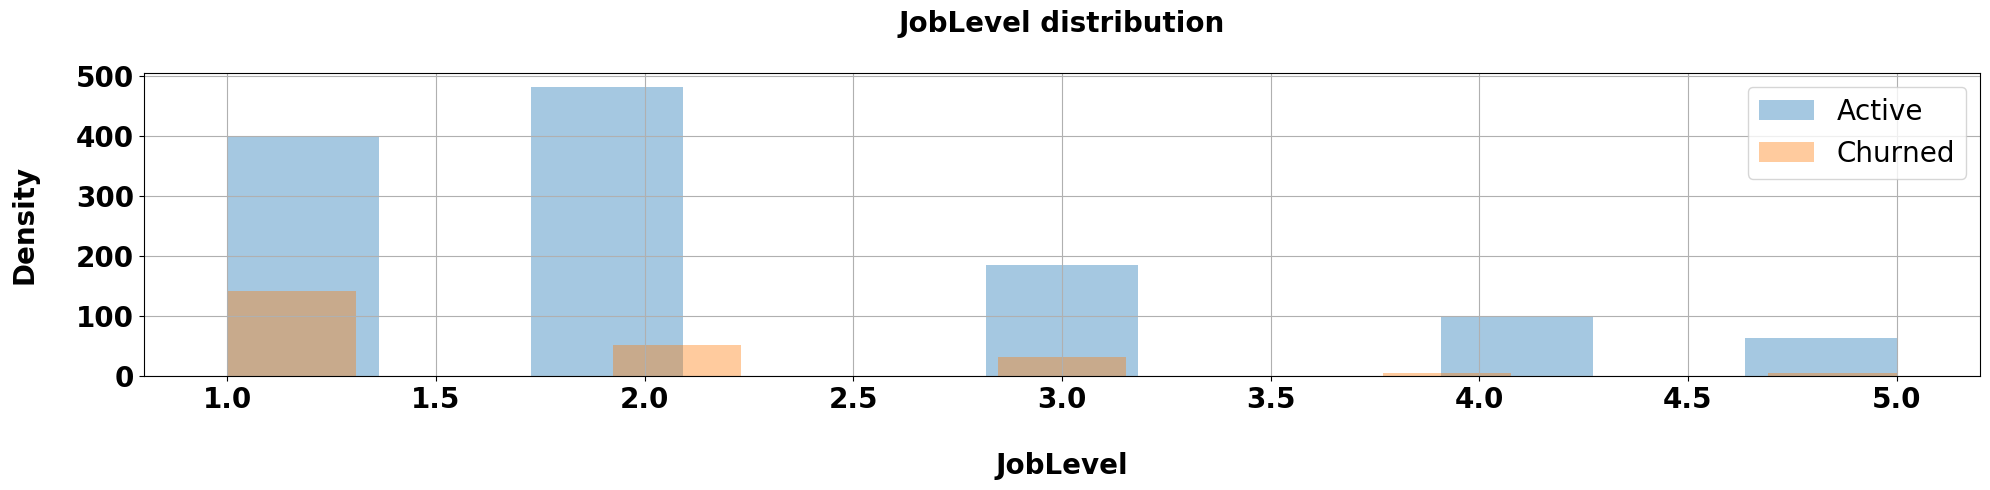

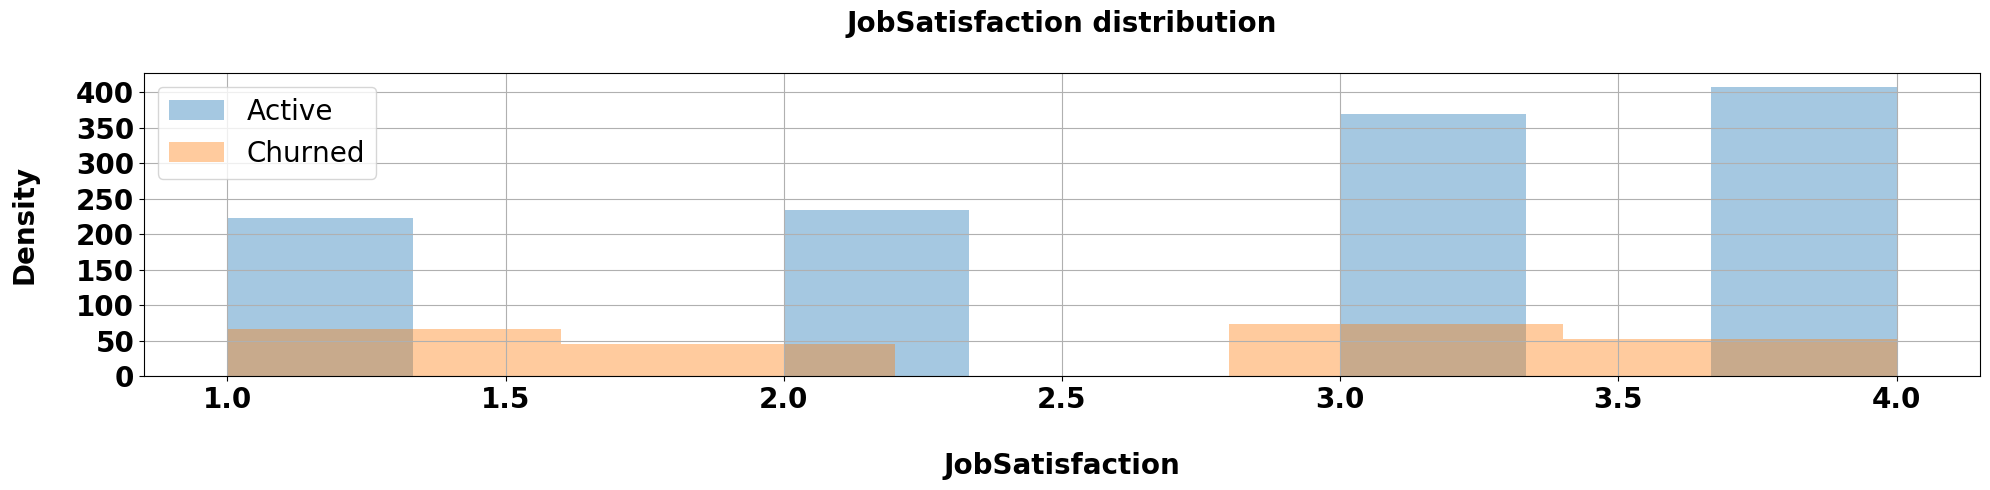

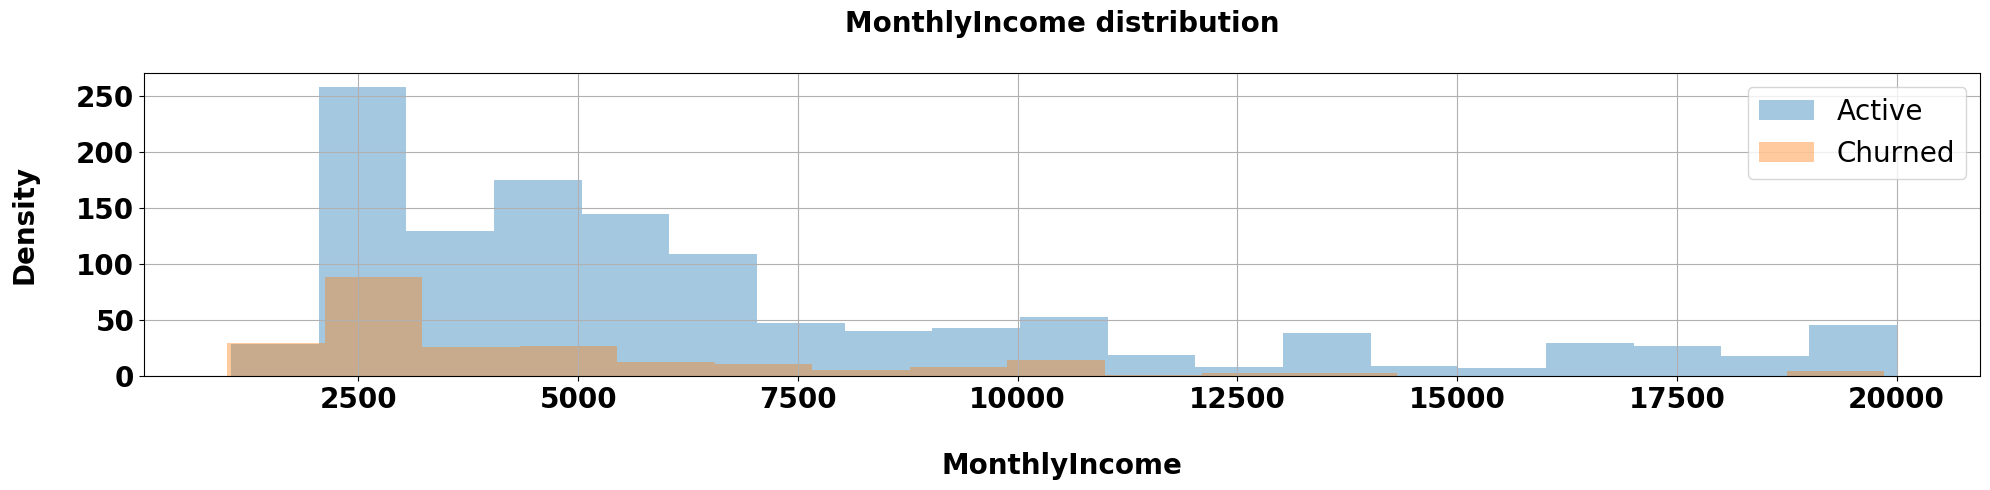

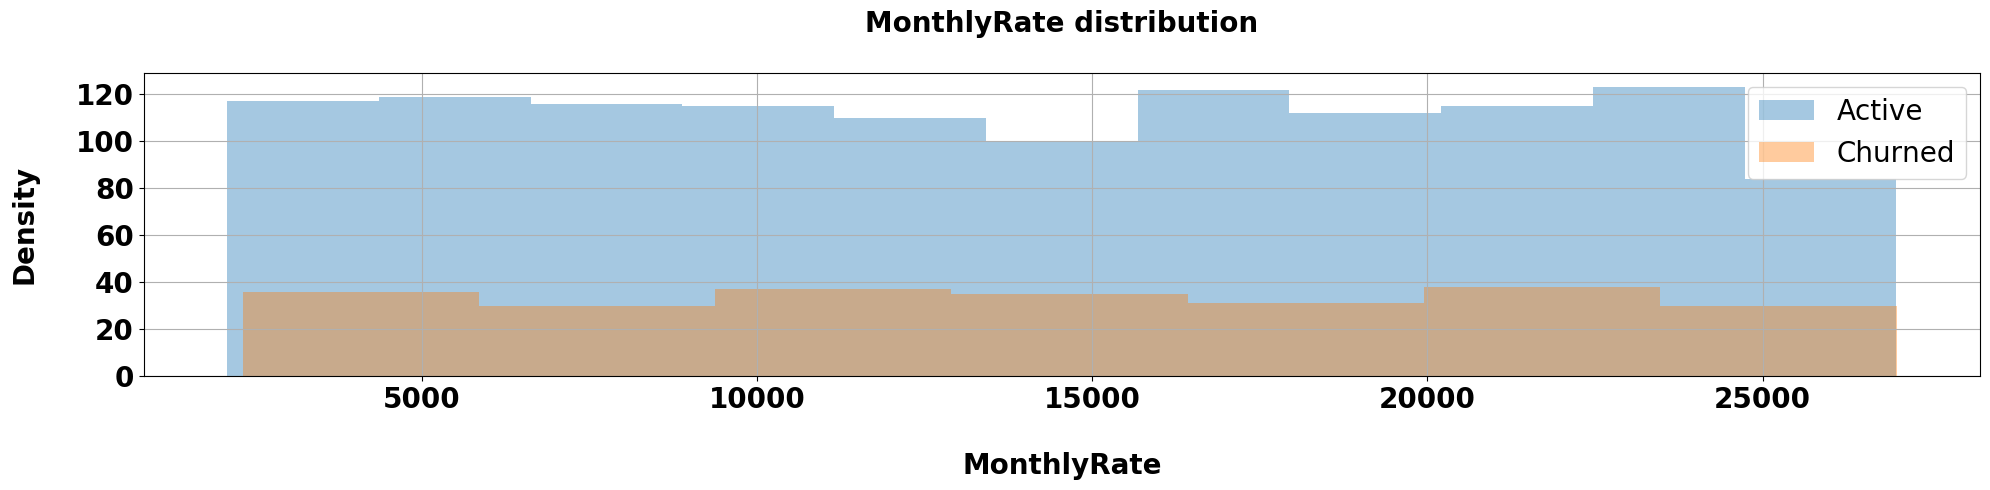

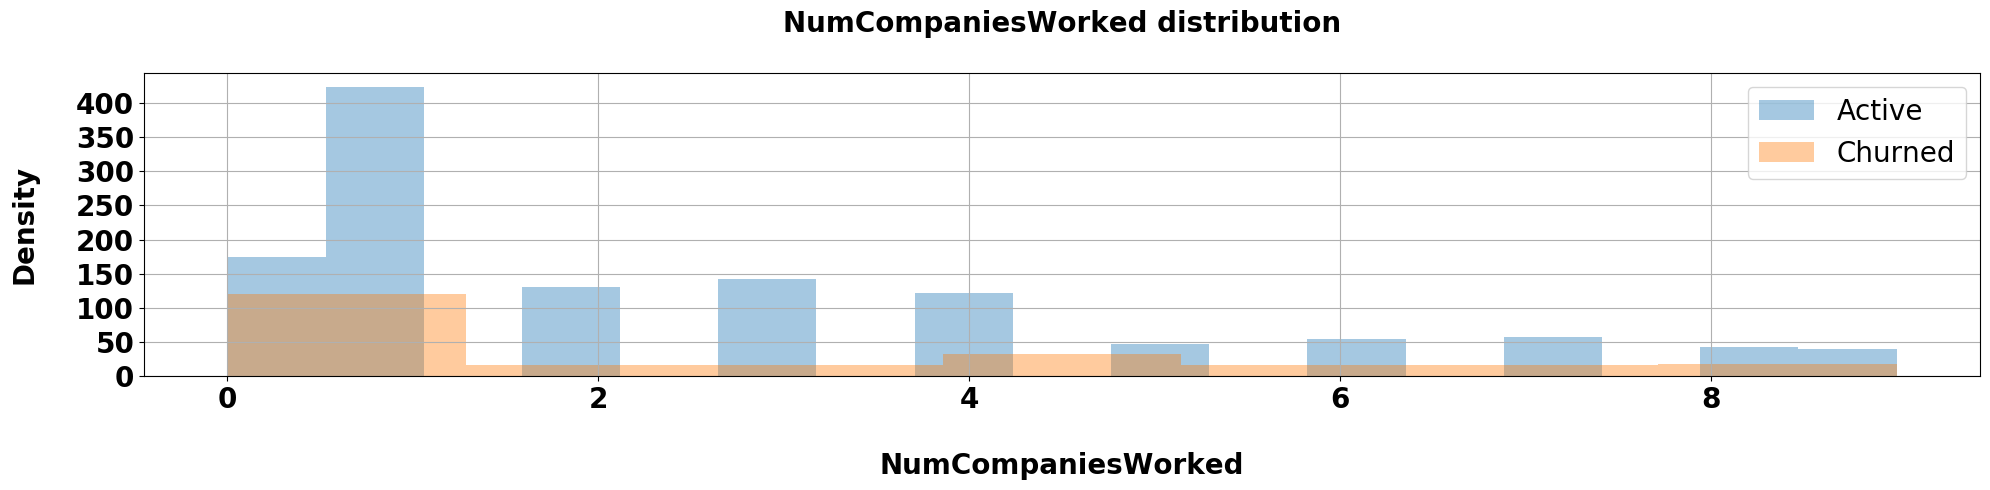

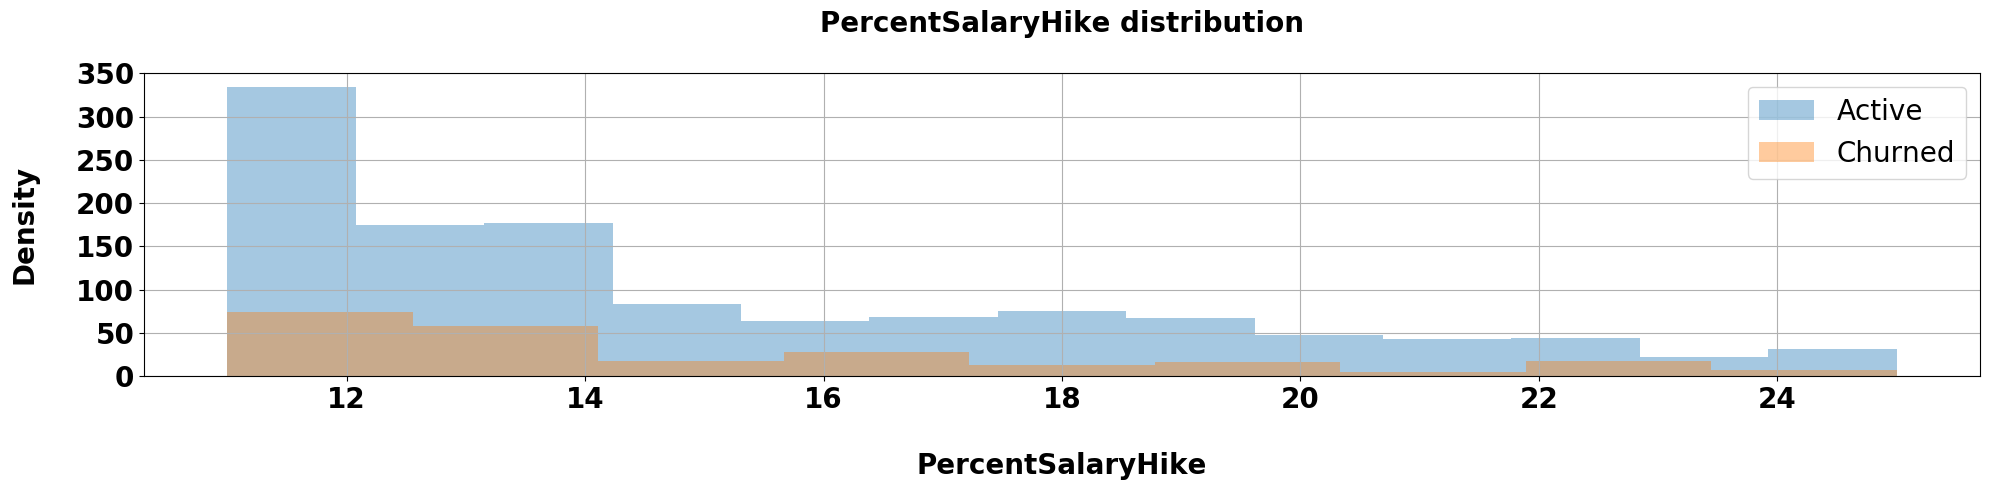

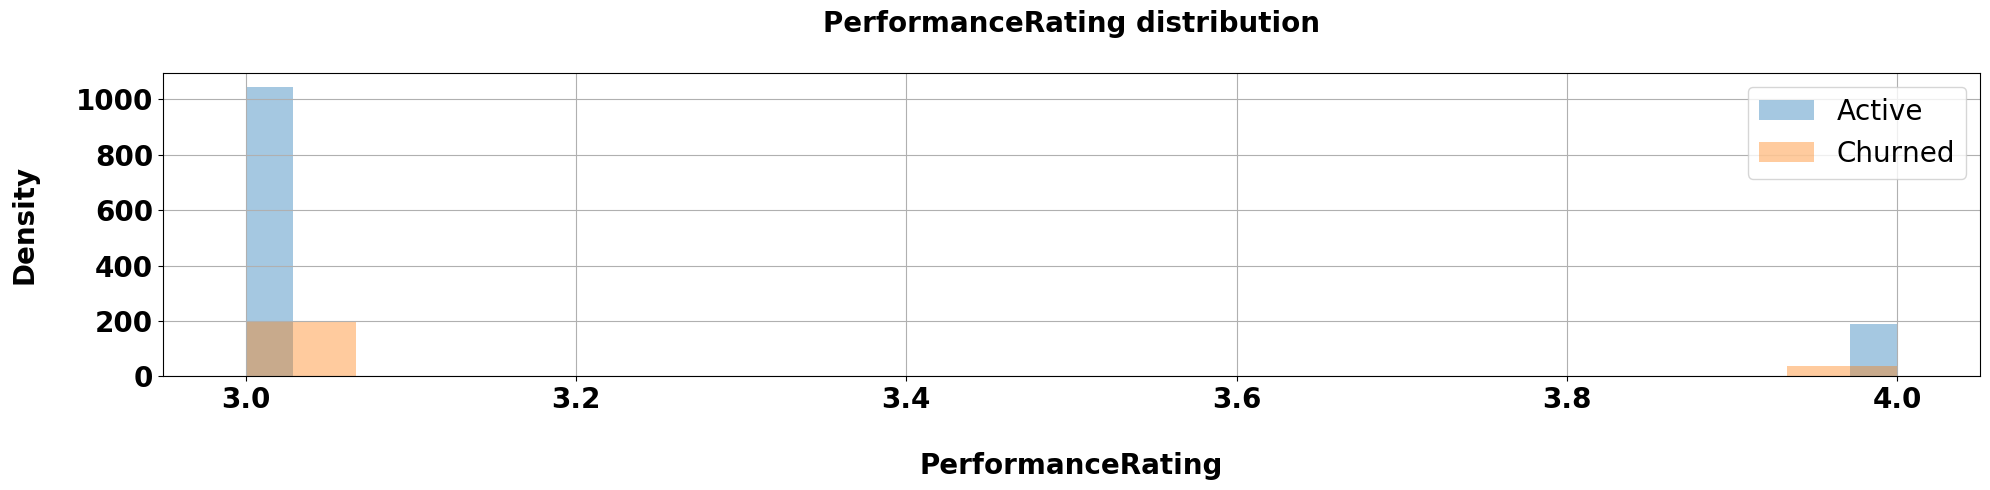

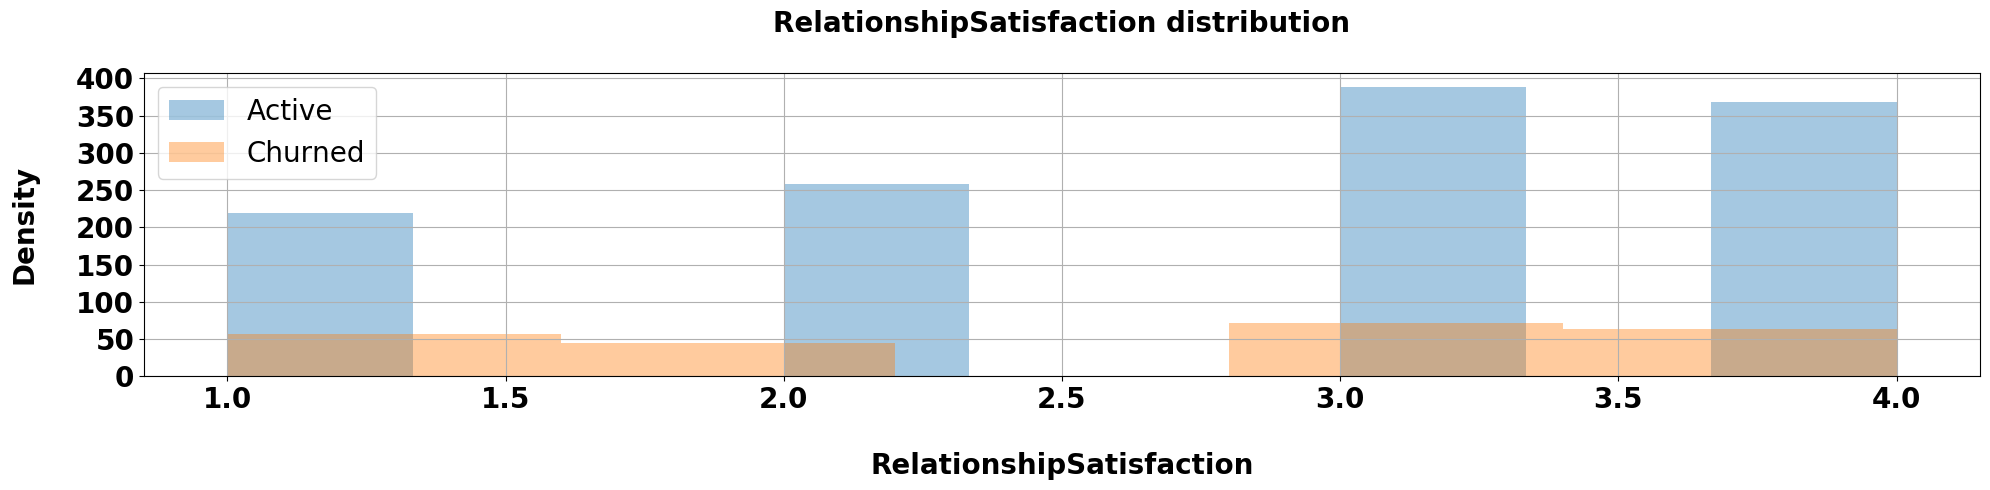

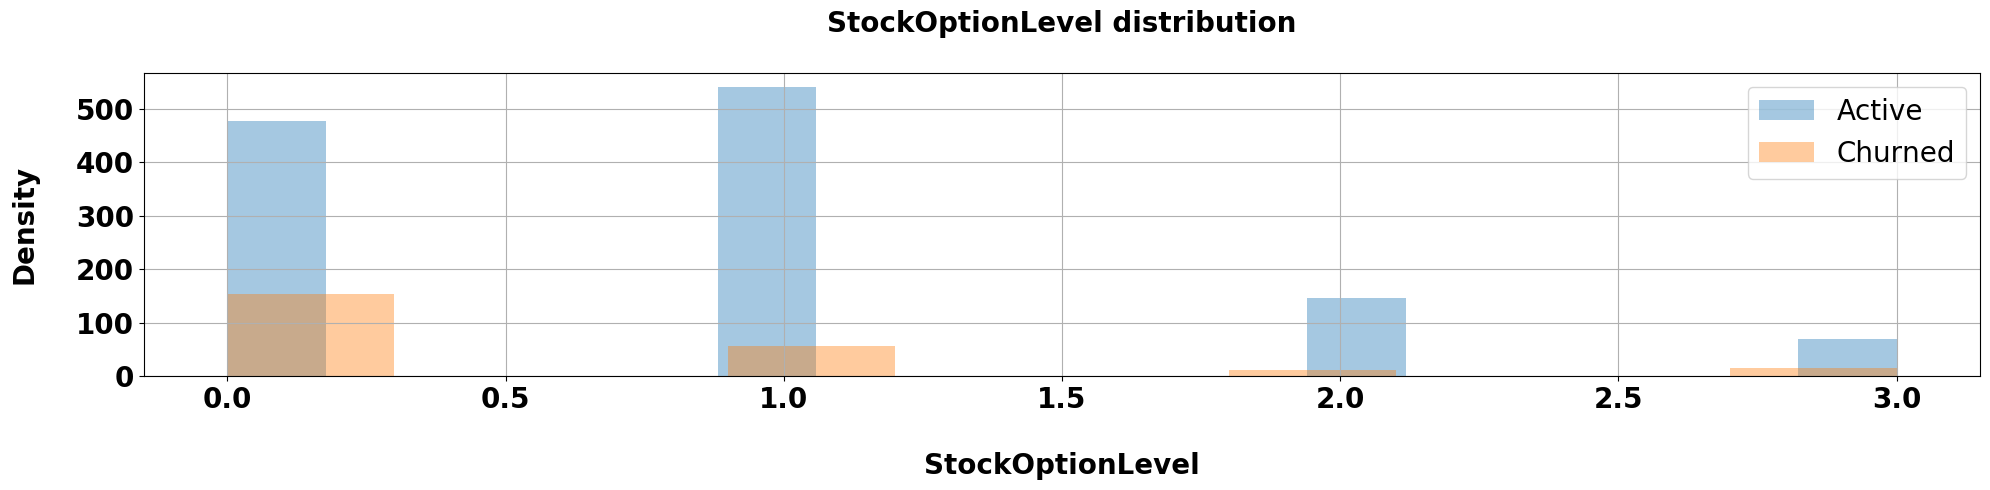

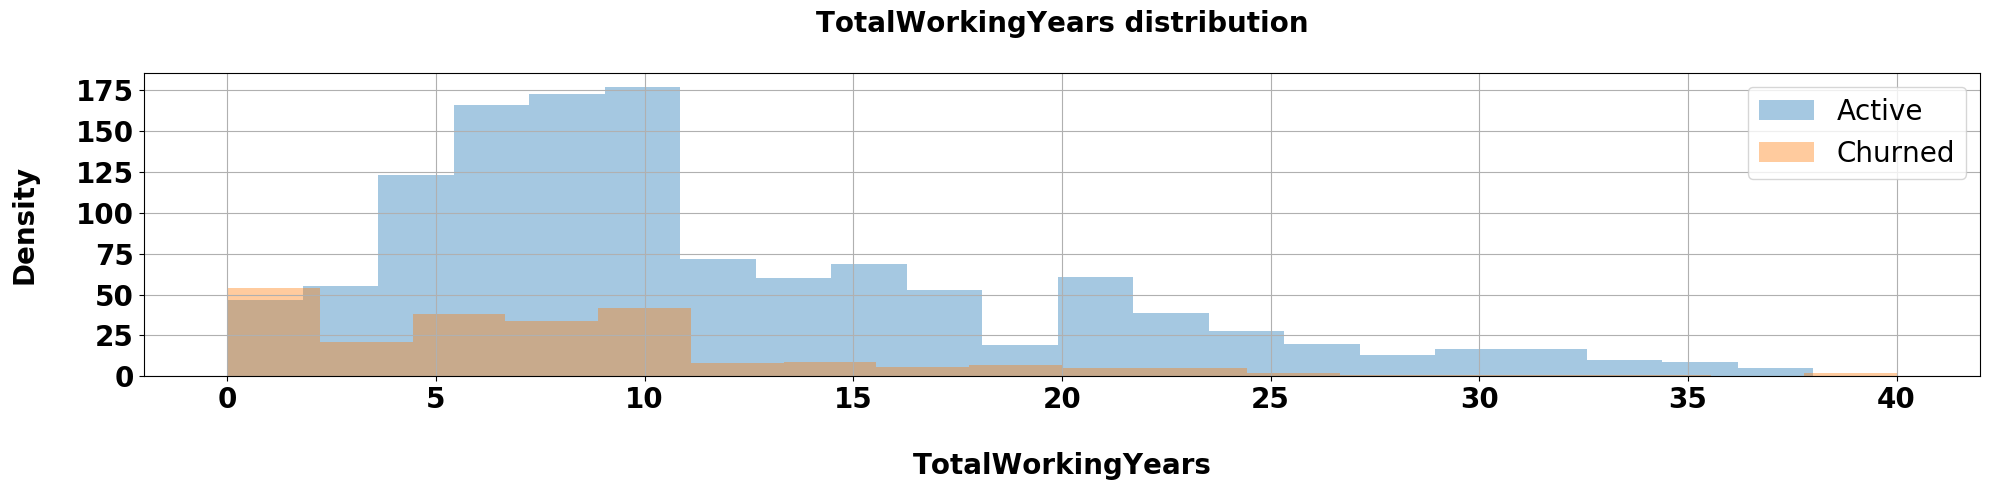

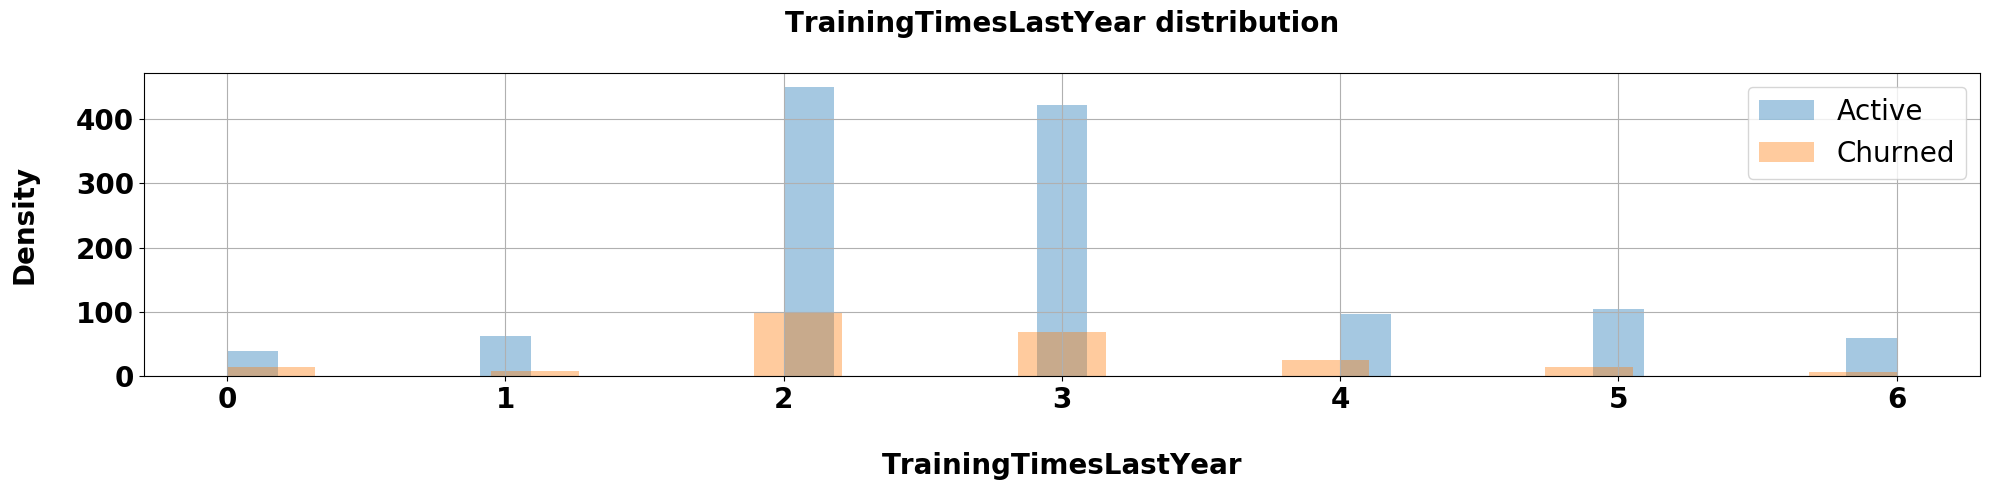

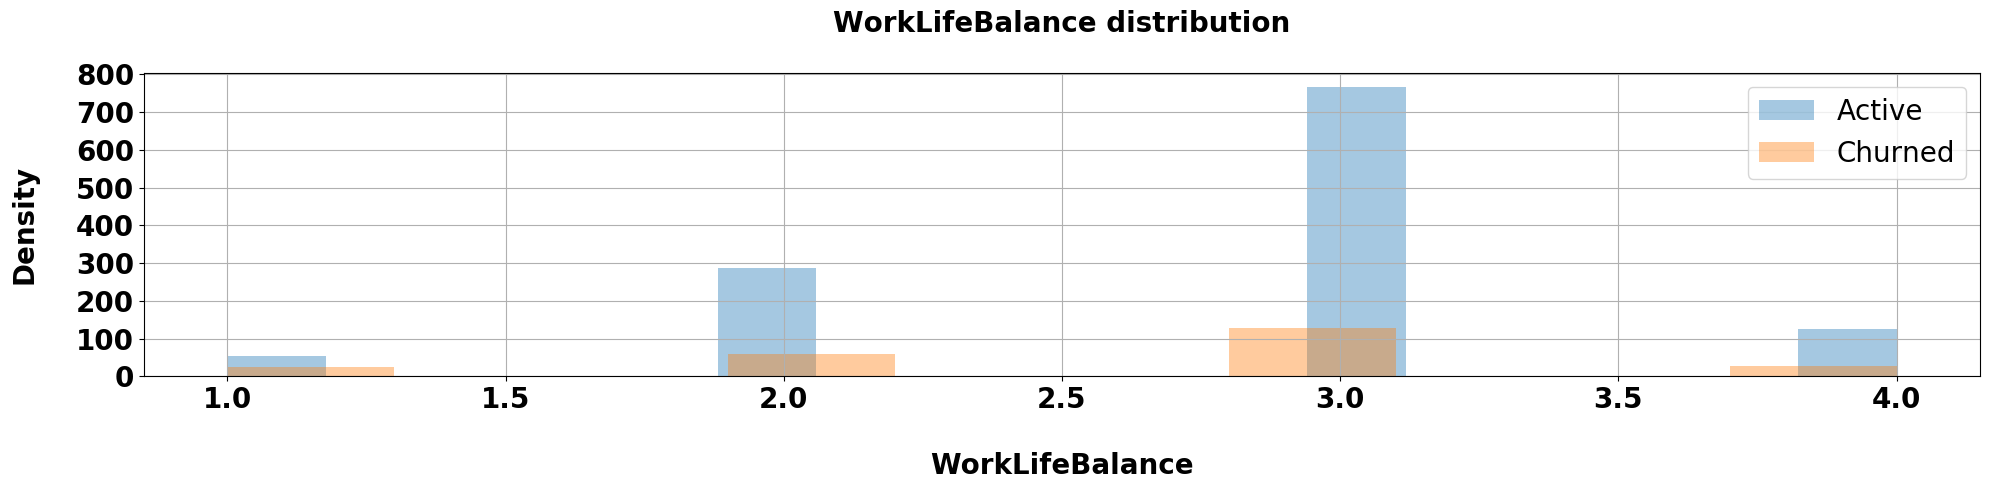

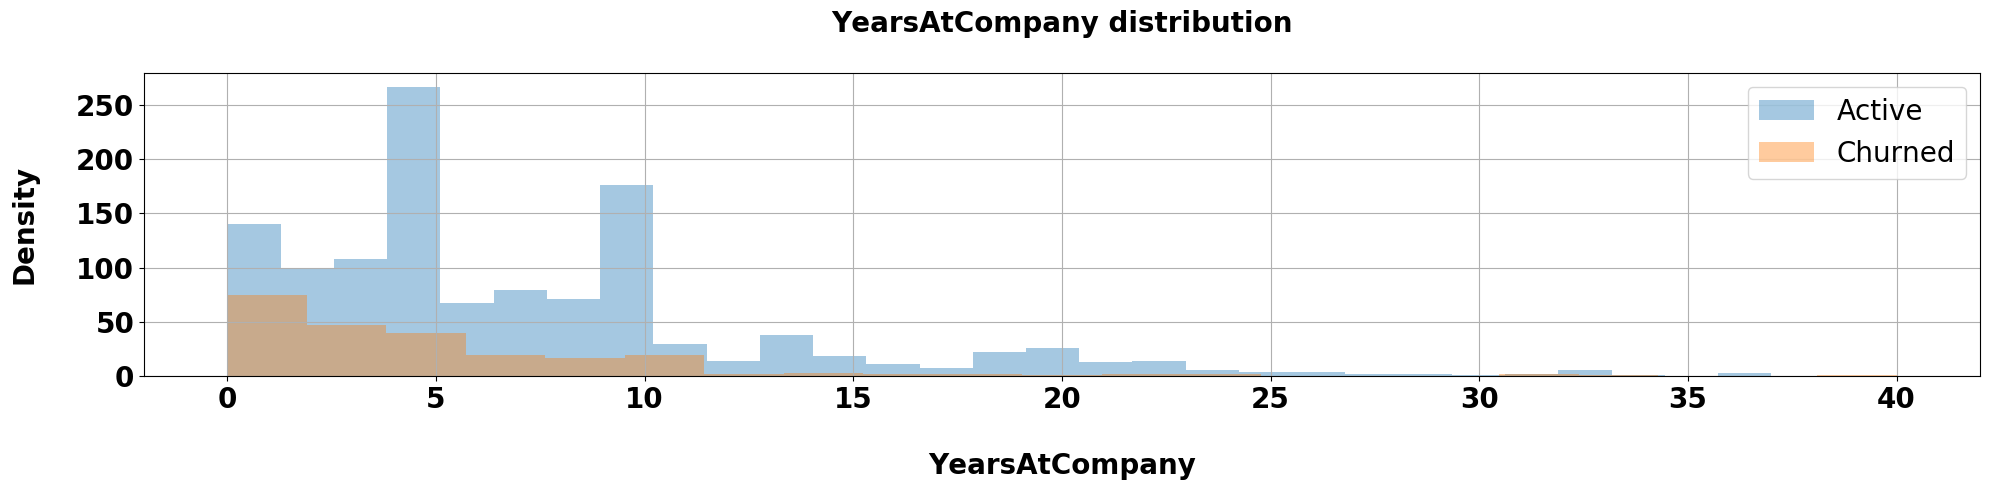

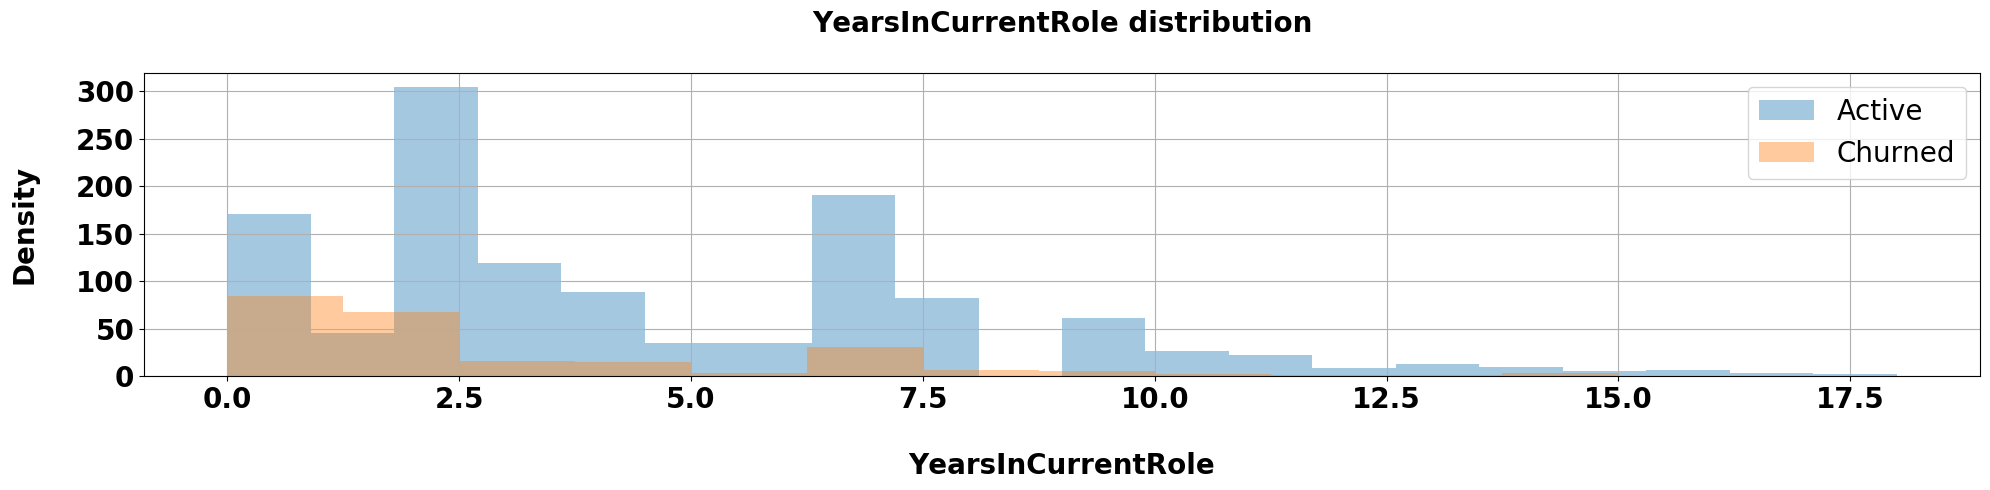

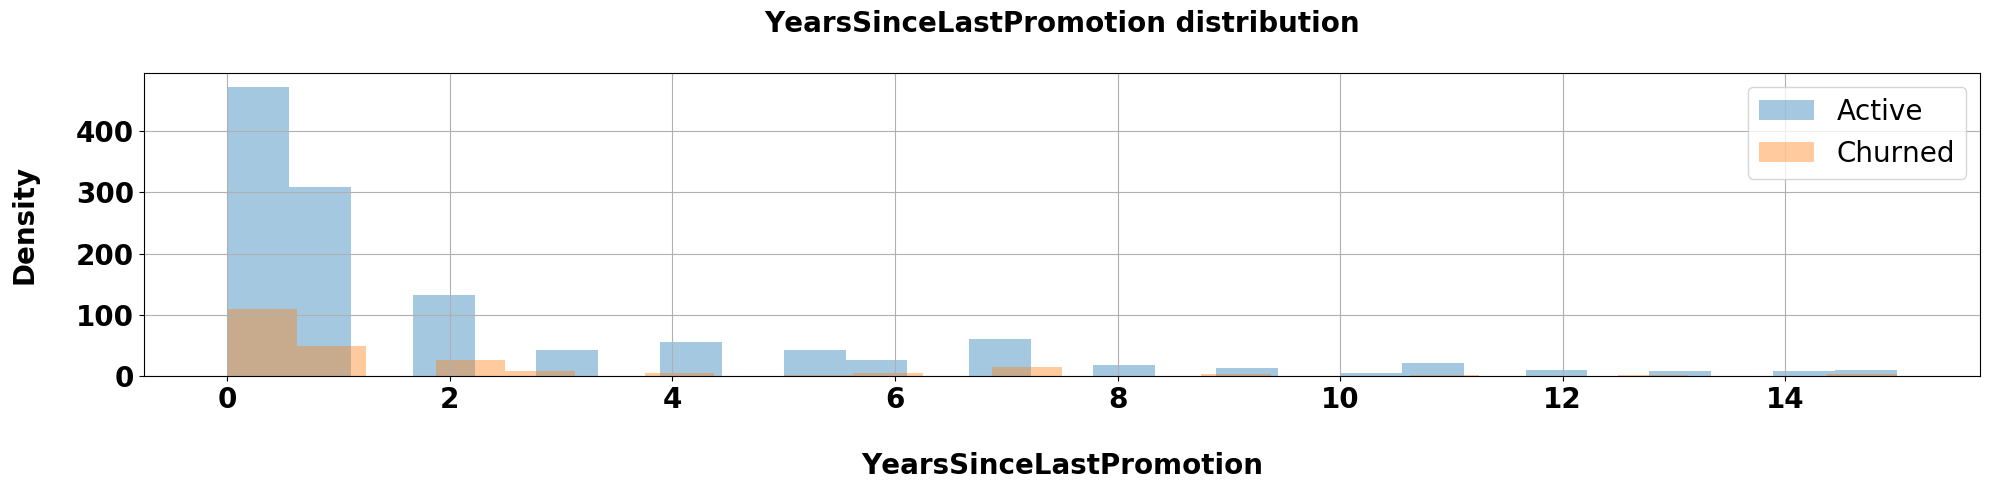

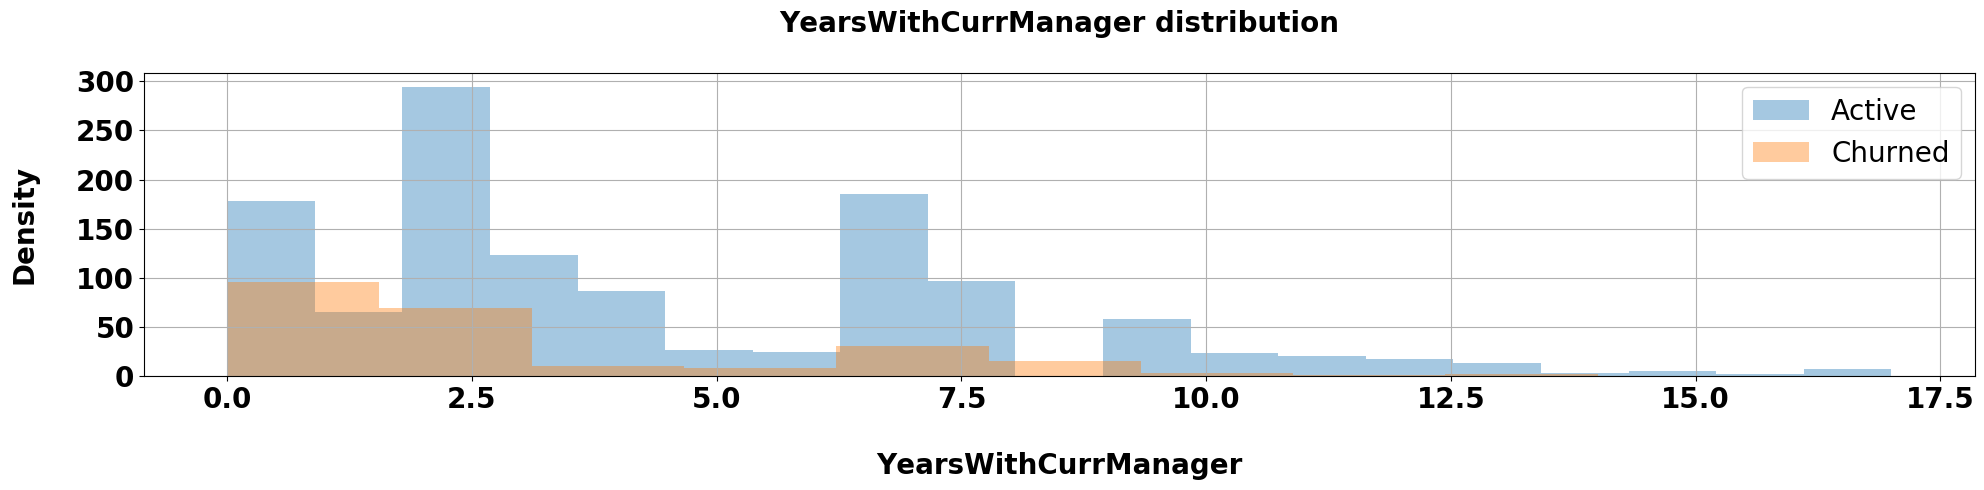

In [10]:
plt.clf()
plt.style.use('default')
font_opts = {'fontsize':20,'fontweight':'bold'}

#####################################################
#####################################################

churned = df.loc[df['Attrition'] == 1]
retained = df.loc[df['Attrition']== 0]

for col in ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 
            'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 
            'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
            'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 
            'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']:

    plt.figure(figsize=(20,5))

    sns.distplot(retained[col], kde=False)
    sns.distplot(churned[col], kde=False)
    plt.xticks(**font_opts)
    plt.yticks(**font_opts)
    plt.xlabel('\n'+col, **font_opts)
    plt.ylabel('Density\n', **font_opts)
    plt.title('{} distribution\n'.format(col), **font_opts)
    plt.grid()
    plt.legend(['Active', 'Churned'], fontsize=20);

    plt.tight_layout()
    plt.plot();

Quando olhamos para as demais distribuições vemos que a maior parte delas é altamente skewed.<br>
Porém dentro de seus contextos e valores apresentados, as mesmas parecem razoáveis.<br><br>

Exploremos agora as suas correlações.

In [11]:
corr = df.copy()
corr = df[['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'HourlyRate', 
           'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
           'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears',
           'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 
           'YearsWithCurrManager', 'Attrition']]

<Figure size 640x480 with 0 Axes>

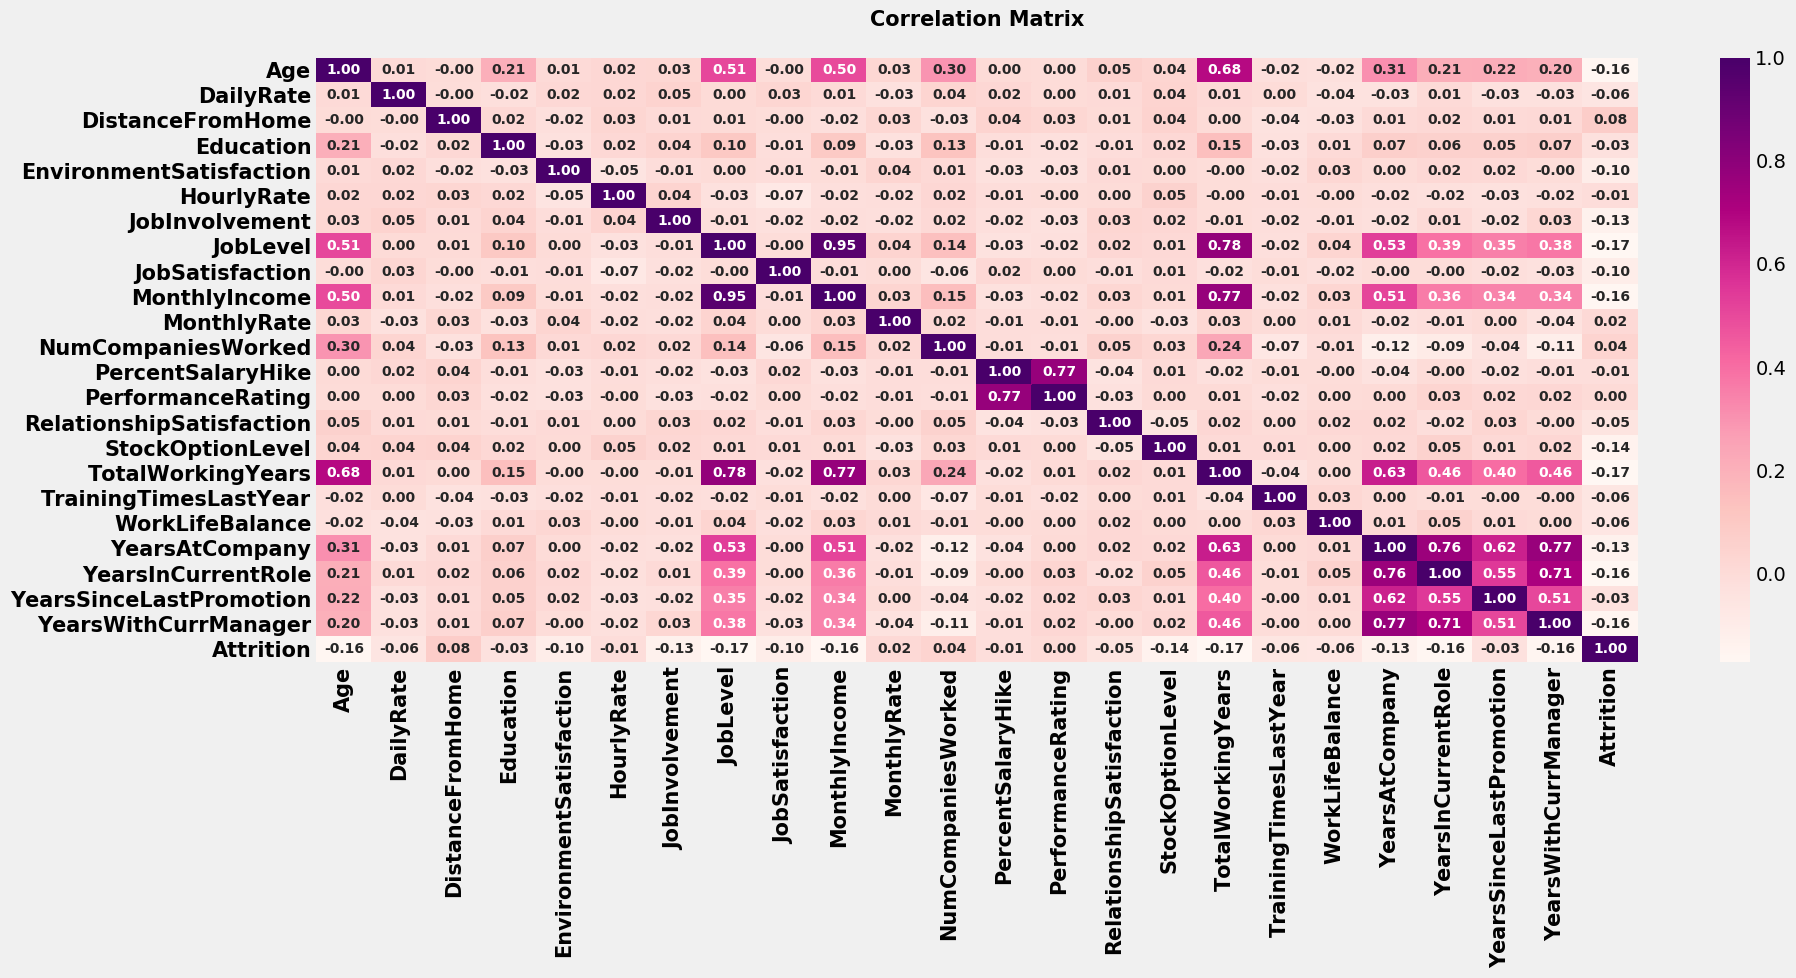

In [12]:
plt.clf()
plt.style.use('fivethirtyeight')
font_opts = {'fontsize':15, 'fontweight':'bold'}
plt.figure(figsize=(20,10))

#####################################################
#####################################################

x = sns.heatmap(
    corr.corr(), 
    annot=corr.corr(), 
    fmt='.2f', 
    annot_kws={'fontsize':10, 'fontweight':'bold'},
    cmap='RdPu'
)

plt.title("Correlation Matrix\n", **font_opts)
plt.xticks(**font_opts)
plt.yticks(**font_opts)


plt.tight_layout()
plt.plot();

In [13]:
corr_values = [value for value in np.hstack(corr.corr()['Attrition'].values) if value !=1]

print("Max corr: {}".format(max(corr_values)))
print("Min corr: {}".format(min(corr_values)))

Max corr: 0.07792358295570358
Min corr: -0.17106324613622528


No geral as correlações são baixas.<br><br>

Olhando mais a fundo que vemos que algumas correlações não parecem fazer sentido...<br>
Esperava uma correlação positiva entre DailyRate, HourlyRate e MonthlyRate. Não é o caso.<br>
Isso não significa necessariamente que a feature não tem correlação, apenas que o método de transformação não é ideal.<br><br>

Vamos prosseguir com as análises gráficas.

<Figure size 640x480 with 0 Axes>

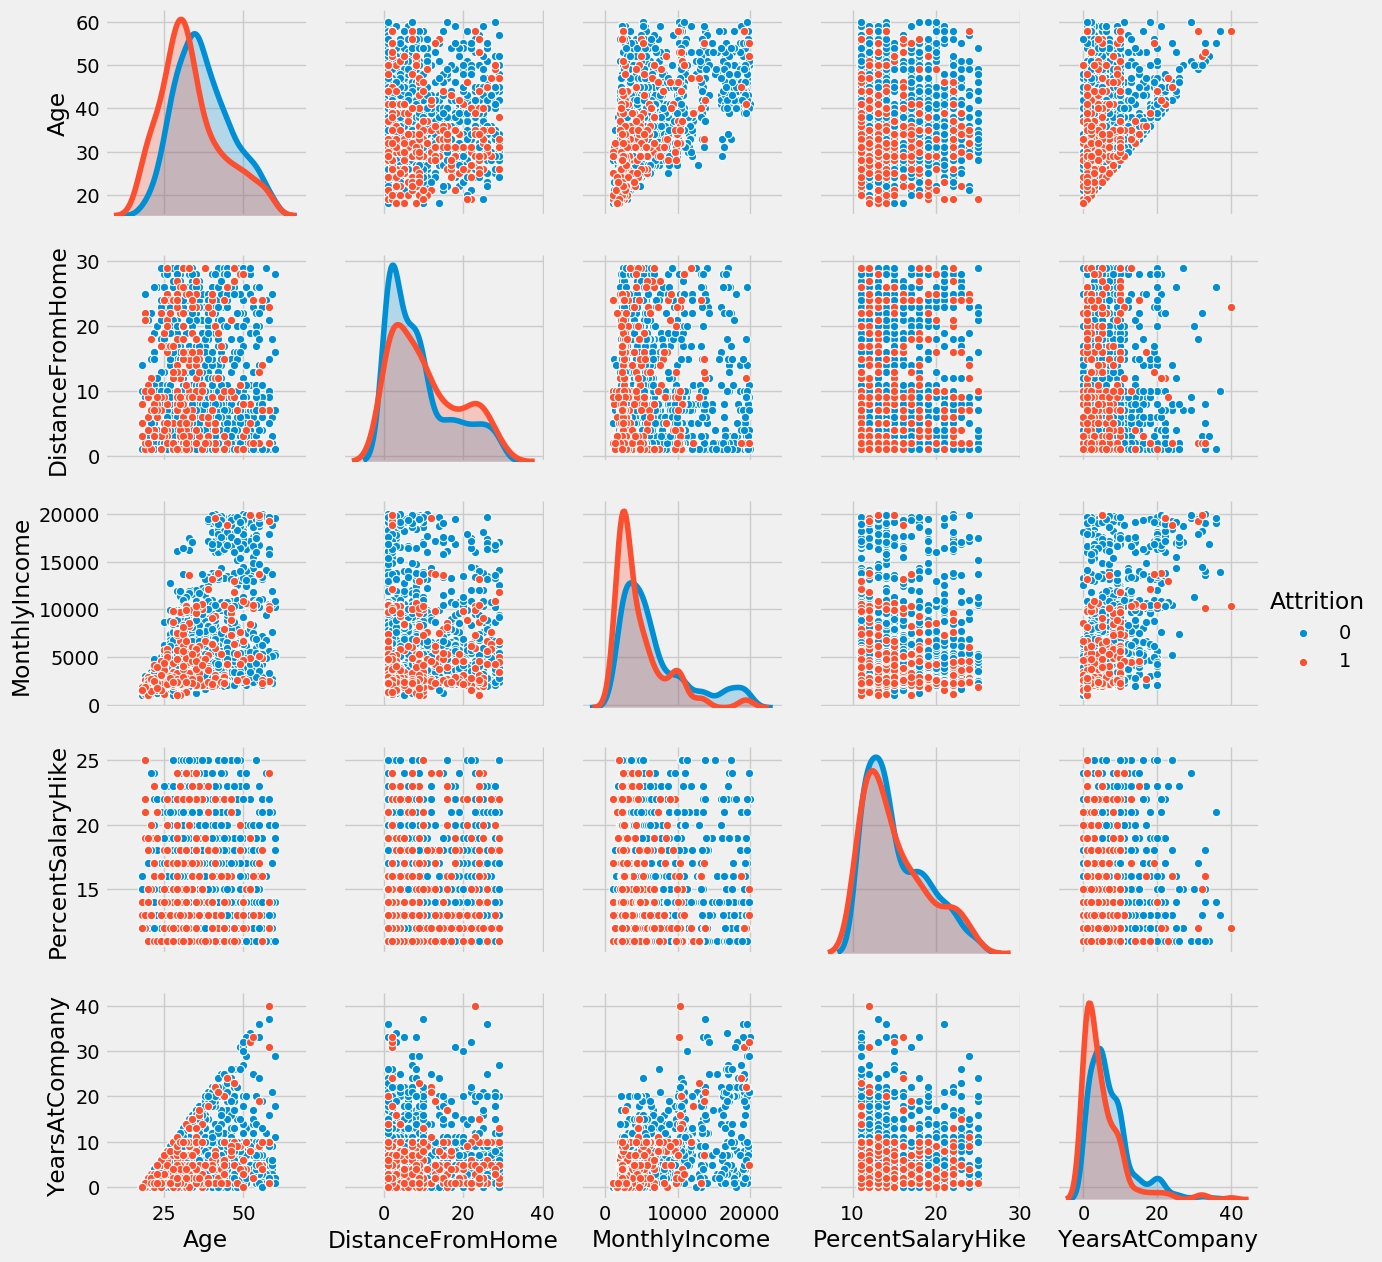

In [14]:
plt.clf()
plt.style.use('fivethirtyeight')
font_opts = {'fontsize':15, 'fontweight':'bold'}

#####################################################
#####################################################

pair_plot = df[["Age","DistanceFromHome","MonthlyIncome","PercentSalaryHike","YearsAtCompany", "Attrition"]]

sns.pairplot(pair_plot, hue="Attrition")
plt.plot();

- A rotatividade parece ser maior em funcionários com menos tempo de casa;
- A renda mensal parece ser um fator determinante para a saída dos funcionários;
- Saída da empresa parece ser mais comum em pessoas mais jovens.<br><br>

Por fim, exploremos as variáveis categóricas e sua correlação com o target.

<Figure size 640x480 with 0 Axes>

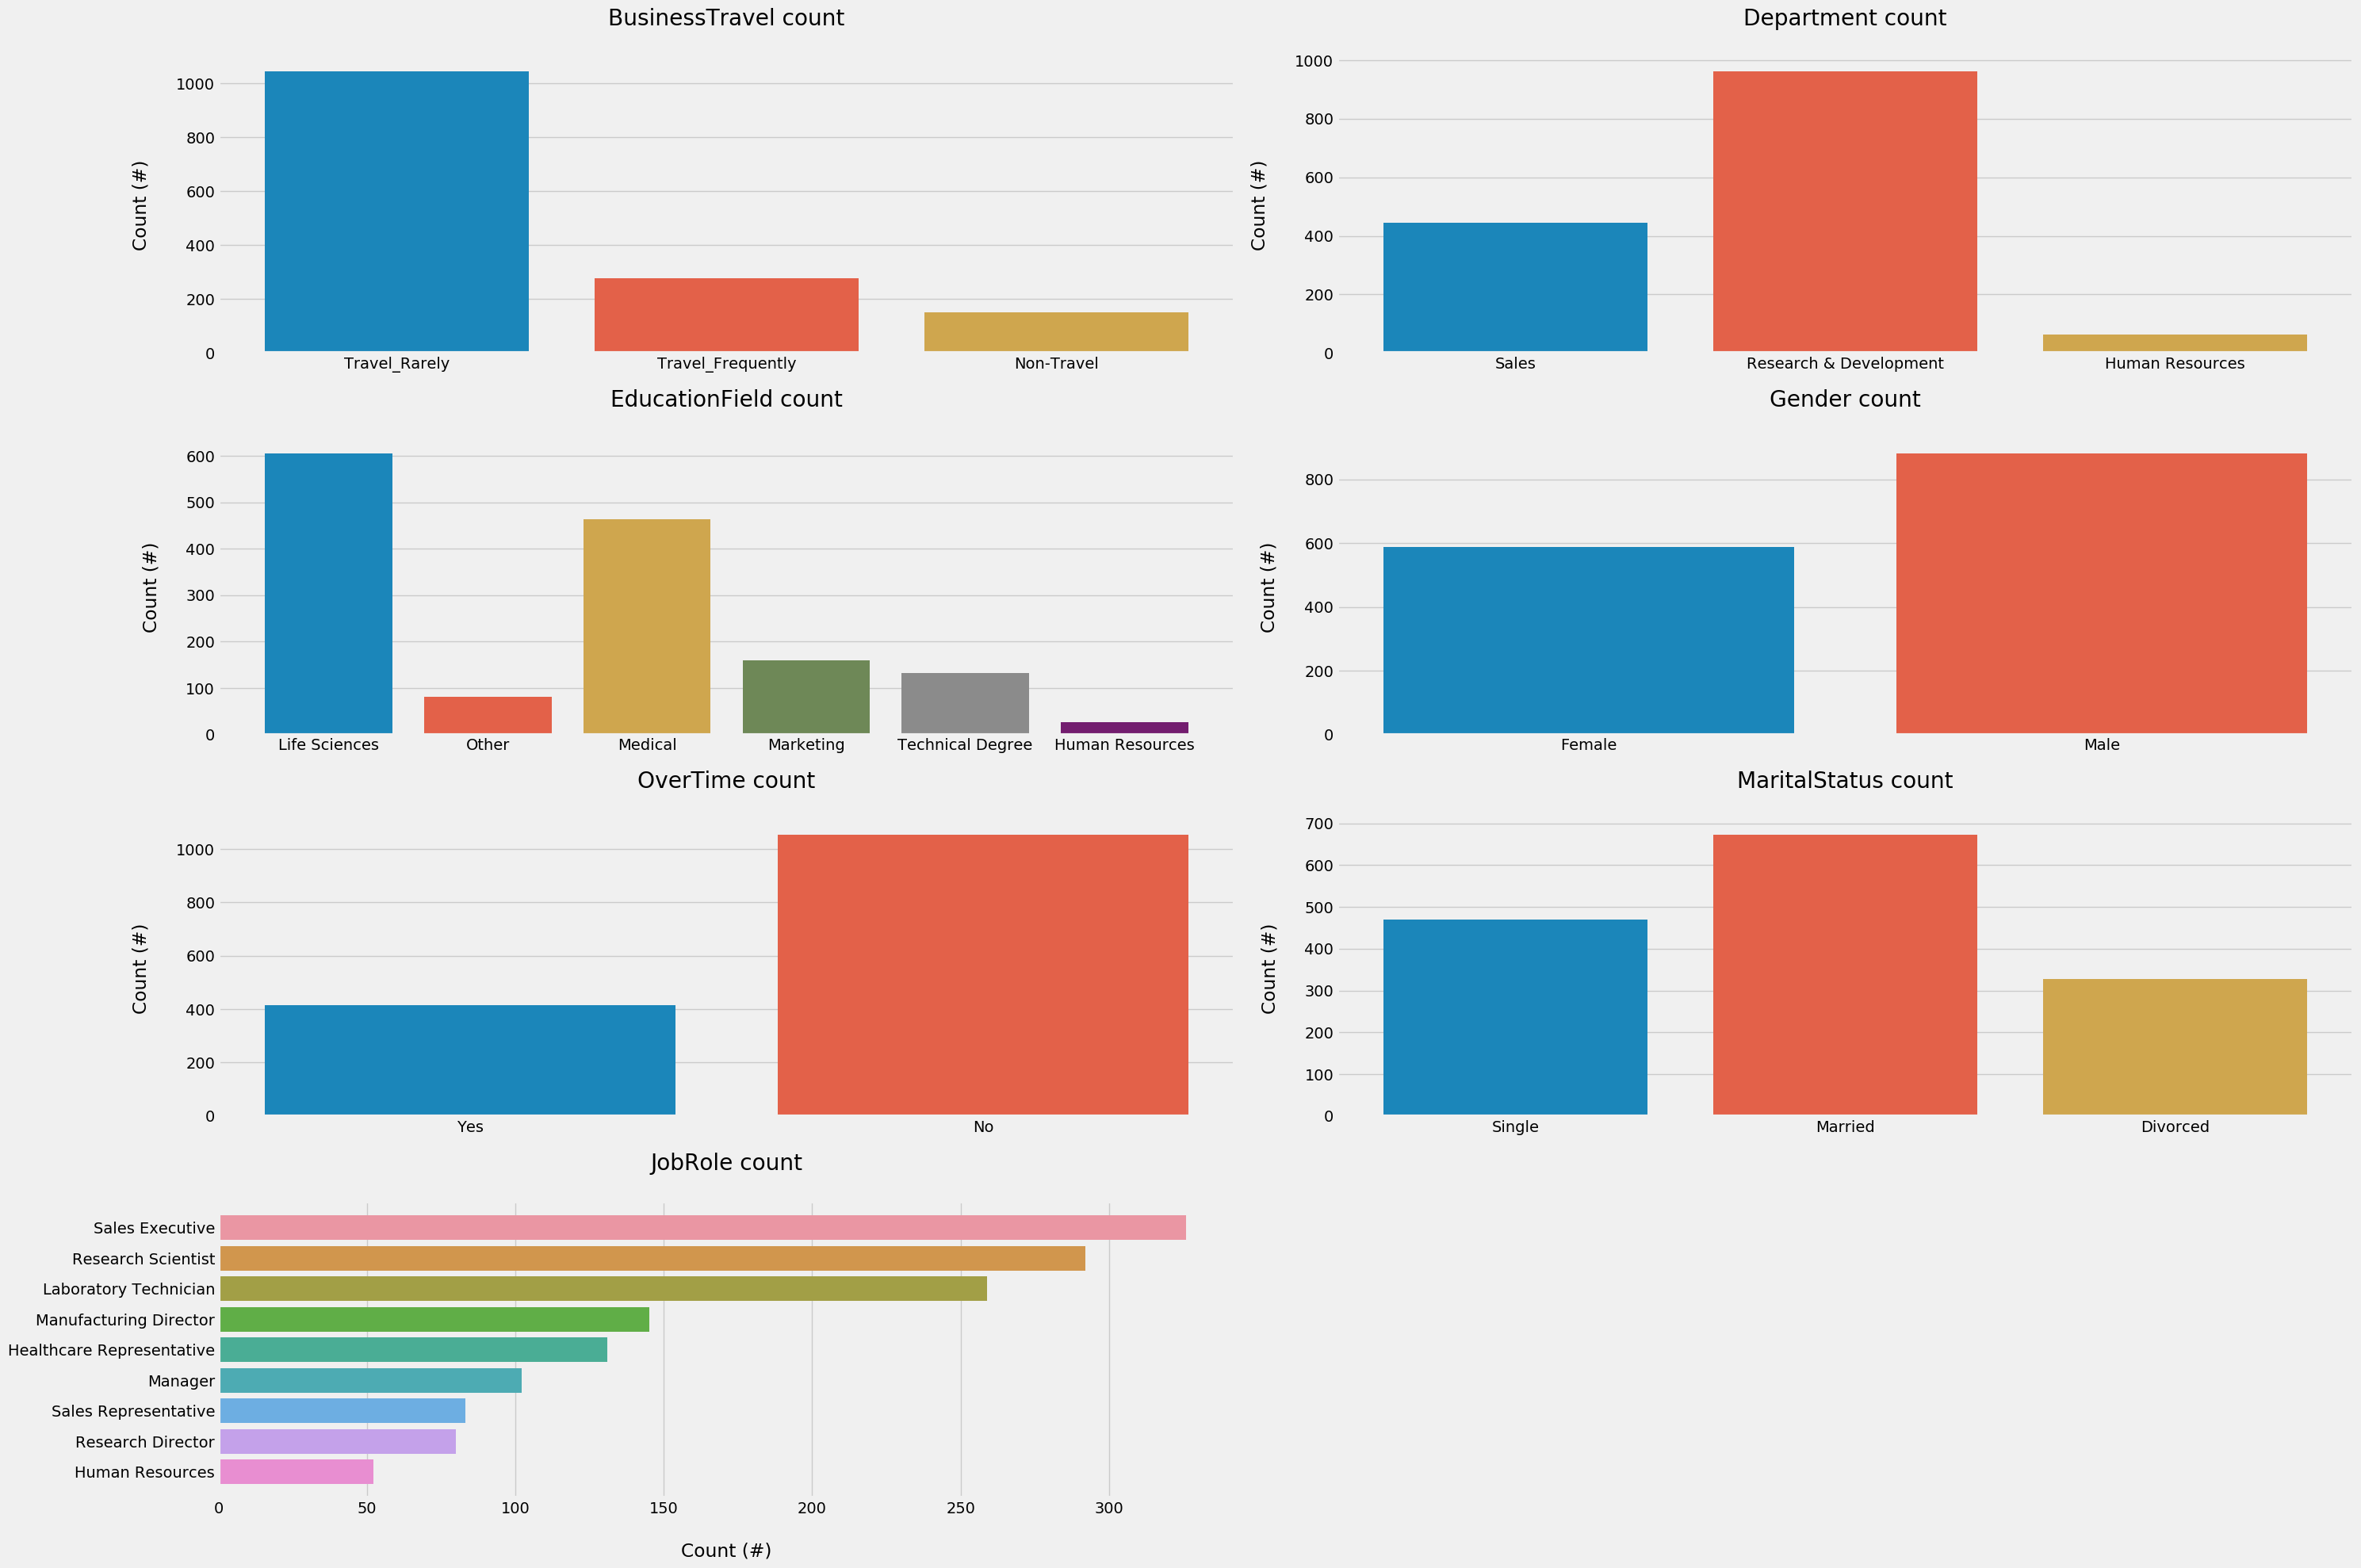

In [15]:
plt.clf()
plt.style.use('fivethirtyeight')
plt.figure(figsize=(30,20))

#####################################################
#####################################################

categorical_features = ["BusinessTravel","Department","EducationField","Gender","OverTime","MaritalStatus","JobRole"]

for index, col in enumerate(categorical_features, 1):
    plt.subplot(4, 2, index)
    
    if col == "JobRole":
        ax = sns.countplot(y=f"{col}", data=df)
        plt.xlabel("\nCount (#)")
        plt.ylabel("")
    else:
        ax = sns.countplot(x=f"{col}", data=df)
        plt.xlabel("")
        plt.ylabel("Count (#)\n")
        
    plt.title('{} count\n'.format(col))

    plt.tight_layout()
    plt.plot();

<Figure size 640x480 with 0 Axes>

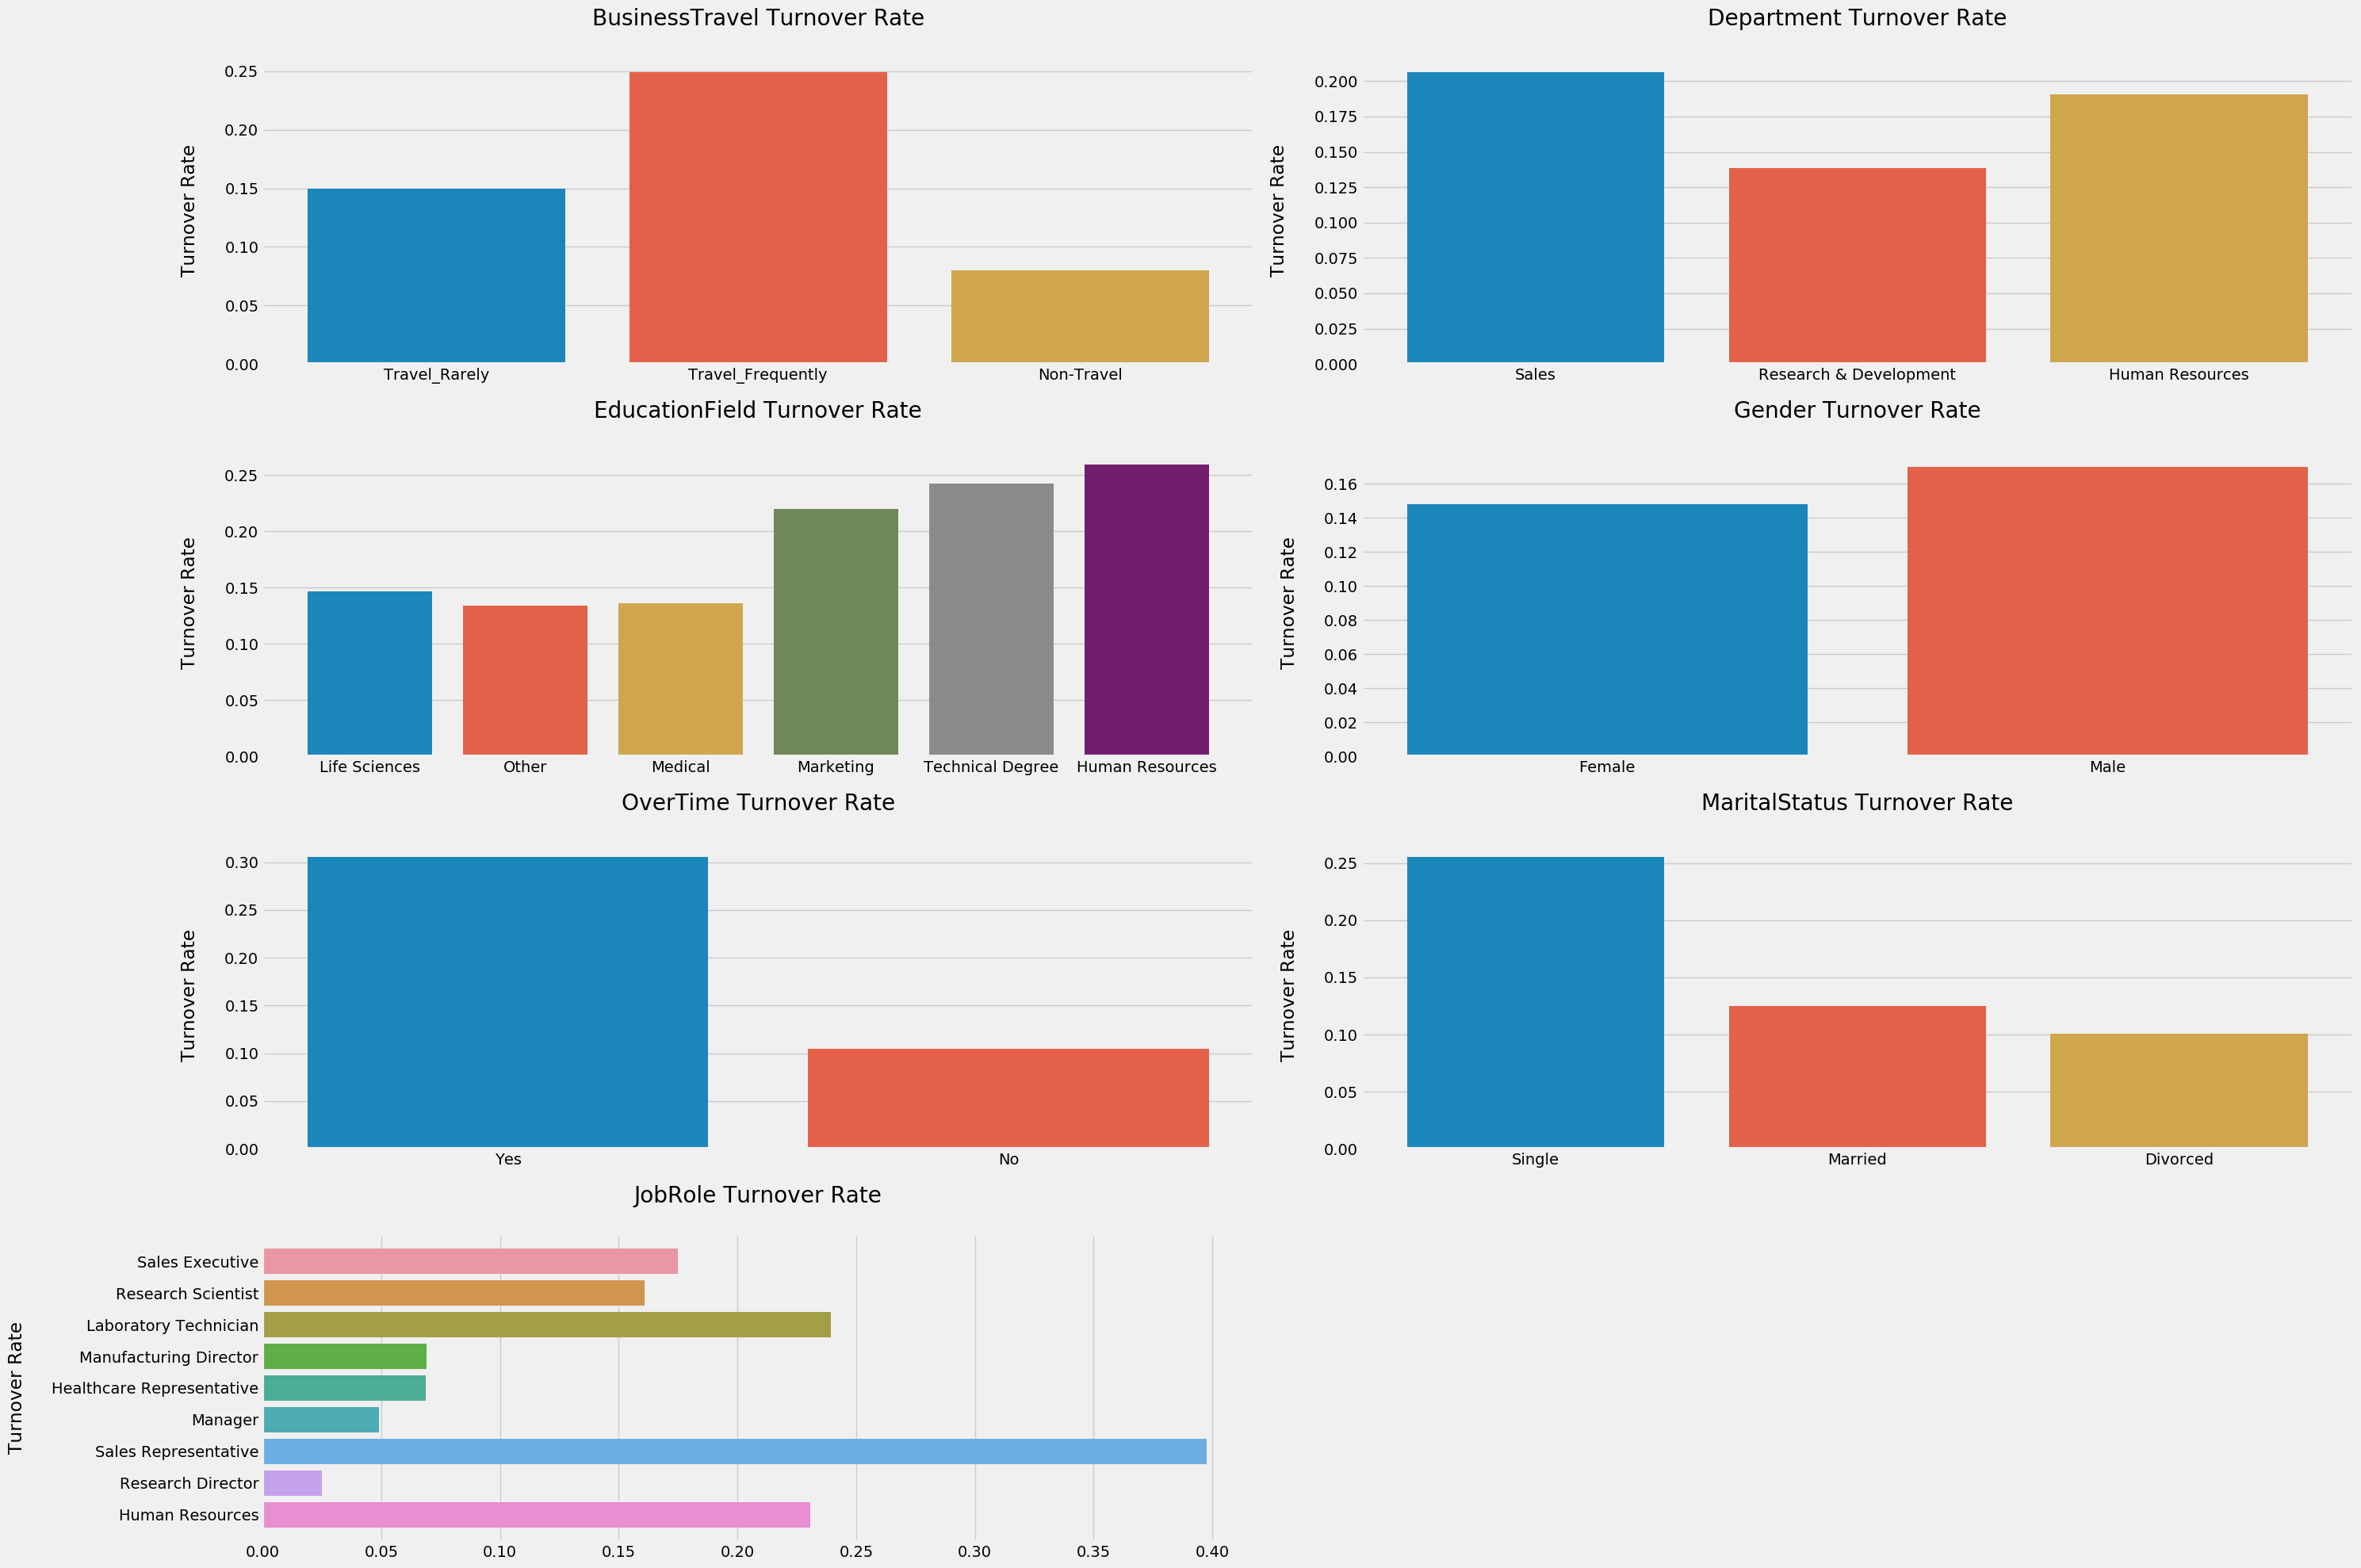

In [16]:
plt.clf()
plt.style.use('fivethirtyeight')
plt.figure(figsize=(30,20))

#####################################################
#####################################################

categorical_features = ["BusinessTravel","Department","EducationField","Gender","OverTime","MaritalStatus","JobRole"]

for index, col in enumerate(categorical_features, 1):
    plt.subplot(4, 2, index)
    
    if col == "JobRole":
        ax = sns.barplot(x="Attrition", y=f"{col}", data=df, ci=False)
        plt.xlabel("\nTurnover Rate")
        plt.ylabel("")
    else:
        ax = sns.barplot(x=f"{col}", y='Attrition', data=df, ci=False)
    plt.title('{} Turnover Rate\n'.format(col))
    plt.xlabel("")
    plt.ylabel("Turnover Rate\n")
    
    
    plt.tight_layout()
    plt.plot();

<Figure size 640x480 with 0 Axes>

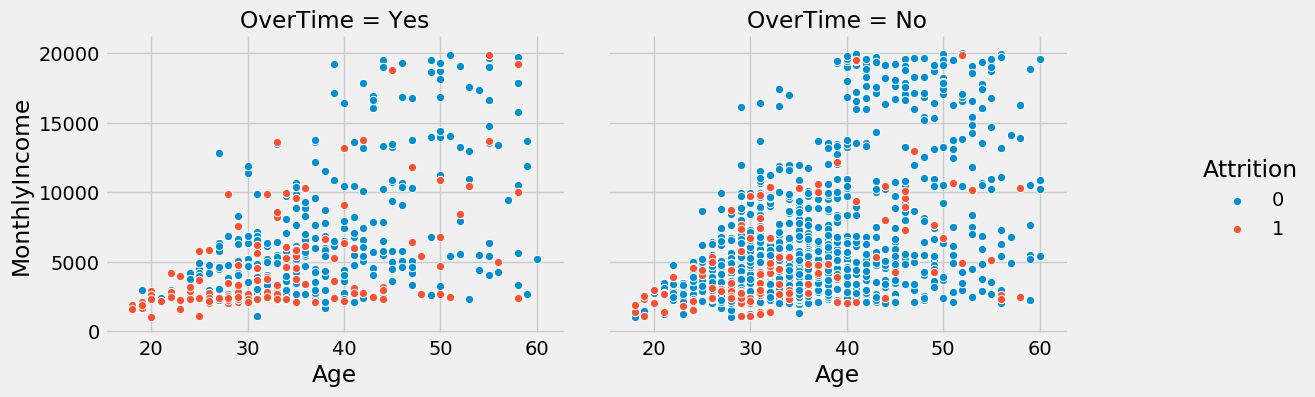

In [17]:
plot_scatterplot(df, "OverTime", (15,5), 2)

<Figure size 640x480 with 0 Axes>

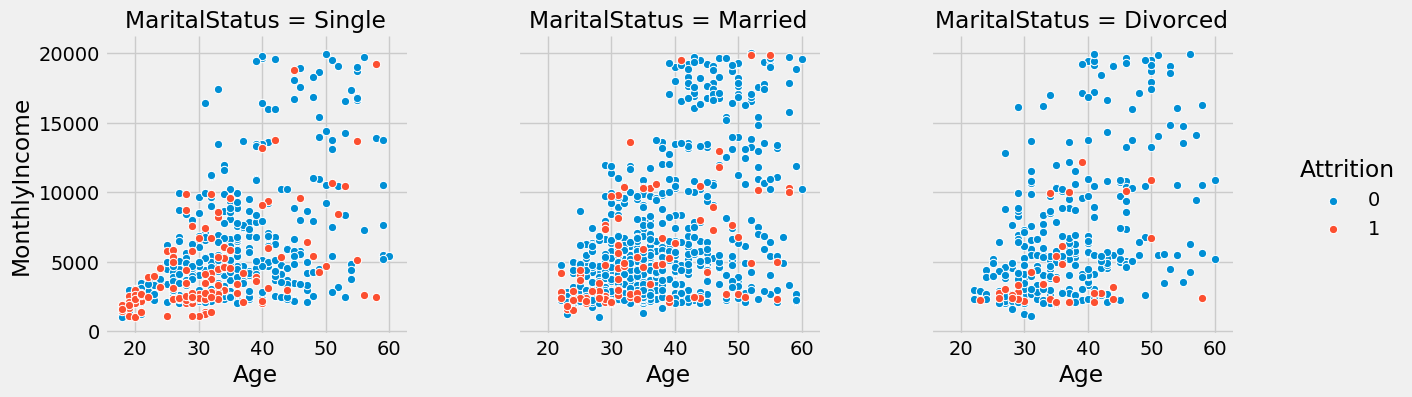

In [18]:
plot_scatterplot(df, "MaritalStatus", (15,5), 3)

<Figure size 640x480 with 0 Axes>

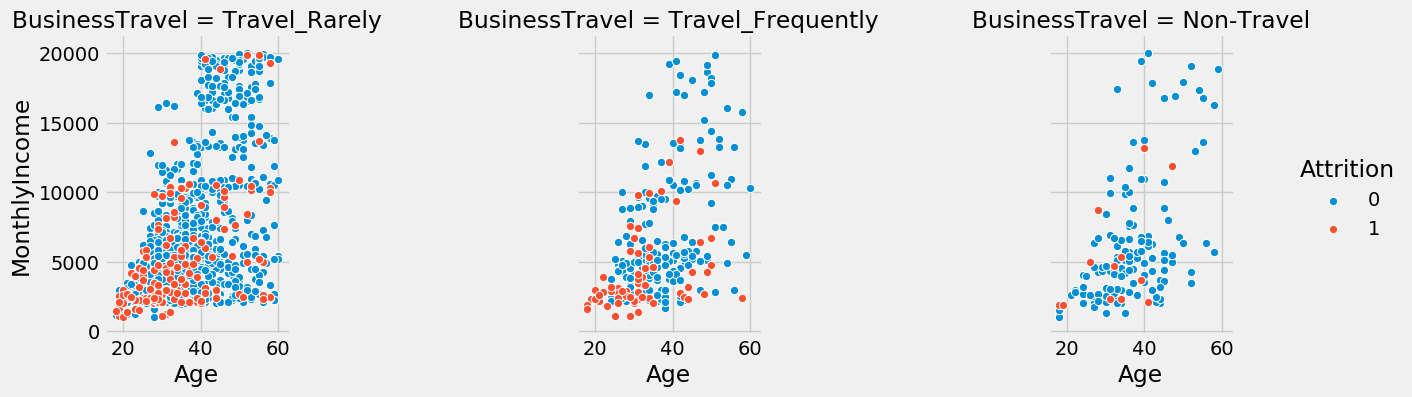

In [19]:
plot_scatterplot(df, "BusinessTravel", (15,5), 3)

# Conclusões inicias

- Target é skewed - ruim para modelos de regressão;
- Correlações são em geral baixas;
- A renda mensal parece ser um dos principais motivadores para a saída dos funcionários (comum em funcionários mais jovens);
- Alguns grupos de funcionários apresentam proporções maiores de turnover:
    - Viagens frequentes;
    - Solteiros;
    - Fazem hora extra;
    - Dos departamentos de Sales e de Human Resources;
    - Nas posições de Sales Representative, Laboratory Technician e Human Resources.<br><br>
    
Com isso concluímos esse notebook.<br>
No próximos notebook namoraremos os dados.